Étude de stabilité et calcul automatique de CFL pour un transport linéaire
===

Table des matières

* [1. Discrétisation en espace](#1.-Discrétisation-en-espace)
	* [1.1 Présentation de la méthode WENO5](#1.1-Présentation-de-la-méthode-WENO5)
		* [1.1.1 Linéarisation du schéma WENO5](#1.1.1-Linéarisation-du-schéma-WENO5)
		* [1.1.2 Étude du schéma WENO5 non linéarisé](#1.1.2-Étude-du-schéma-WENO5-non-linéarisé)
	* [1.2 Méthodes WENO modifiées](#1.2-Méthodes-WENO-modifiées)
		* [1.2.1 WENO-M](#1.2.1-WENO-M)
		* [1.2.2 WENO-Z](#1.2.2-WENO-Z)
	* [1.3 BWENO](#1.3-BWENO)
	* [1.4 WENO3](#1.4-WENO3)
* [2. Discrétisation en temps](#2.-Discrétisation-en-temps)
	* [2.1 Méthodes Runge-Kutta explicites](#2.1-Méthodes-Runge-Kutta-explicites)
		* [2.1.1 Obtention de la fonction de stabilité depuis un schéma numérique](#2.1.1-Obtention-de-la-fonction-de-stabilité-depuis-un-schéma-numérique)
		* [2.1.2 Obtention de la fonction de stabilité depuis un tableau de Butcher](#2.1.2-Obtention-de-la-fonction-de-stabilité-depuis-un-tableau-de-Butcher)
		* [2.1.3 Récapitulatif des domaines des différentes méthodes en temps](#2.1.3-Récapitulatif-des-domaines-des-différentes-méthodes-en-temps)
		* [2.1.4 Recherche du meilleur domaine de stabilité](#2.1.4-Recherche-du-meilleur-domaine-de-stabilité)
		* [2.1.5 Order star](#2.1.5-Order-star)
	* [2.2 Méthode diagonal implicit Runge-Kutta](#2.2-Méthode-diagonal-implicit-Runge-Kutta)
* [3. Étude de couples RK($s$,$n$)-WENO5](#3.-Étude-de-couples-RK%28$s$,$n$%29-WENO5)
	* [3.1 Automatisation du calcul de CFL](#3.1-Automatisation-du-calcul-de-CFL)
		* [3.1.1 CFL RK($s$,$n$) - WENO linéarisé](#3.1.1-CFL-RK%28$s$,$n$%29---WENO-linéarisé)
* [4. Schémas Runge-Kutta exponentiels](#4.-Schémas-Runge-Kutta-exponentiels)
	* [4.1 Schémas exponentiels](#4.1-Schémas-exponentiels)
	* [4.2 Schémas de Lawson](#4.2-Schémas-de-Lawson)


Nous nous intéressons ici à résoudre un problème de transport du type :
$$
  u_t + u_x = 0
$$
avec $x\in [0,1]$ et $t>0$, ainsi que la condition initiale $u_0$ donnée. Les méthodes que nous allons présentées peuvent s'étendre à des problèmes de transport non linéaire : $u_t + f_x(u) = 0$, mais la seule extension qui nous intéresse réellement est un problème de transport à vitesse constante $a$ : $u_t + au_x = 0$.

Pour la discrétisation en espace, nous souhaitons principalement étudier des méthodes WENO ; la discrétisation en temps, quant à elle, se limitera à des méthodes de type Runge-Kutta.

In [1]:
"""
global import, and define common symbols
"""

import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from IPython.display import display
sp.init_printing()

from sympy import I

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
x,y = sp.symbols("x y",real=True)
z   = sp.symbols("z")

class Data(object):
  """
    dummy class to store data
  """
  def __str__(self):
    return "\n".join([ "{} : {}".format(k,v) for k,v in self.__dict__.items()])

default = Data()
default.figsize = plt.rcParams['figure.figsize']

import matplotlib.colors as mcolors # for mcolors.TABLEAU_COLORS
default.palette = list(mcolors.TABLEAU_COLORS)

In [2]:
# if need to reimport `plt` during a working session
from importlib import reload
plt = reload(plt)

In [3]:
def reim(Z):
  """
    function to split into 2 arrays real part and imaginary part of complex array
  """
  complex_to_tuple = lambda z:(z.real,z.imag)
  return tuple(map(list,zip(*map(complex_to_tuple,Z))))

def plot(expr,x,I,*args,**kwargs):
  """
    just plot a SymPy expression `expr` of variable `x` on the interval `I`
  """
  X = np.linspace(I[0],I[1],500)
  F = sp.lambdify(x,expr,'numpy')
  plt.plot(X,F(X),*args,**kwargs)
  
class Data(object):
  """
    dummy class to store data
  """
  pass
data = Data()

# phi array to store angle where evaluate ztilde(phi)
data.phi = np.linspace(0,2.0*np.pi,1000)

# 1. Discrétisation en espace

Pour étudier les schémas en espace nous allons utiliser l'analyse de *von Neumann*, pour cela introduisons quelques fonctions.

In [4]:
"""
  we will use von Neumann analysis to study WENO schemes
  this functions are helpers to write numerical flux of WENO and apply von Neumann analysis with sympy
"""

def f(k):
  """
    return $f_{i+k}$
  """
  if k==0:
    return sp.symbols("f_j")
  return sp.symbols("f_j%+d"%k)
  
def stencil(i_min,i_max) :
  """
    stencil
    return dictionary of (i,f_i) value between `i_min` and `i_max`
  """
  return dict(enumerate( [ f(i) for i in range(i_min,i_max+1) ] , start=i_min ))
f_stencil = stencil(-3,3) # stencil (-3,3) is the size of WENO5 stencil for hight order scheme need to grow up this one

def symbols_to( stencil , func ):
  """
    symbols_to
    convert dictionary `stencil` of `int => sp.Symbols` to dictionary of`sp.Symbols => sp.Symbols`
    useful to replace all $f_i$ symbols by an other value in expression
  """
  return { f:func(j,f) for j,f in stencil.items() }

def symbols_to_vonNeumann( stencil ):
  """
    symbols_to_vonNeumann
    convert all $f_i$ symbols to equivalent in von Neumann analysis with exponential
    $\phi$ symbol need to be initialized
  """
  return symbols_to( stencil , lambda j,_:sp.exp(I*j*phi) )

## 1.1 Présentation de la méthode WENO5

La méthode WENO est une famille de schémas aux différences finies (il existe aussi une interprétation en terme de volumes finis) d'ordre potentiellement élevé, essentiellement non oscillante à l'aide de différentes approximations pondérées. De manière générale, la méthode WENO peut être utilisée pour discrétiser la dérivée spatiale dans un problème de transport du type :

$$
  \partial_tu + \partial_xf(u) = 0
$$

Après une semi-discrétisation en espace du problème, la méthode WENO consiste à approximer les flux numériques tels que :

$$
  \frac{\mathrm{d}u_j}{\mathrm{d}t} = -\frac{1}{\Delta x}\left(\hat{f}_{j+\frac{1}{2}} - \hat{f}_{j-\frac{1}{2}} \right)
$$

où $u_j(t) \approx u(t,x_j)$, $j=0,\dots,N$. La méthode WENO consiste initialement à *spliter* le flux entre sa partie positive et négative :

$$
  f(u) = f^+(u) + f^-(u)
$$

tel que $\frac{\mathrm{d}f^+}{\mathrm{d}u} \geq 0$ et $\frac{\mathrm{d}f^-}{\mathrm{d}u} \leq 0$. Nous noterons par la suite $f^\pm_j$ l\ approximation de $f^\pm(u(x_j))$ où $x_j$ est un point du maillage.

La méthode WENO consiste ensuite à estimer des poids en fonctions d'indicateurs de continuité (*indicators of smoothness*) $\beta_i^\pm$ (parfois noté $IS_i^\pm$), qui sont des combinaisons des carrés des approximations des dérivées successives en $x_j$ (sur des *stencils* potentiellement décentrés). Les coefficients $\beta_i^\pm$ permettent d'estimer des poids $w_i^\pm$, pondérant différentes estimations de la solution toujours en $x_j$ sur les différents *stencils*.

Pour le schéma *standard* WENO d'ordre 5 (aussi appelé WENO-JS pour [[G.-S. Jiang et C.-W. Shu (1996)]](http://doi.org/10.1006/jcph.1996.0130)) il y a 3 estimations sur 3 *stencils* différents :

$$
  \begin{aligned}
    \beta_0^+ &= \frac{13}{12}(\underbrace{f^+_{j-2} - 2f^+_{j-1} + f^+_{j}  }_{\Delta x^2(f''_j + \mathcal{O}(\Delta x))}))^2 + \frac{1}{4}( \underbrace{f^+_{j-2} - 4f^+_{j-1} + 3f^+_{j}}_{2\Delta x( f'_j + \mathcal{O}(\Delta x^2))}  )^2 \\
    \beta_1^+ &= \frac{13}{12}( \underbrace{f^+_{j-1} - 2f^+_{j}   + f^+_{j+1}}_{\Delta x^2(f''_j + \mathcal{O}(\Delta x^2))} )^2 + \frac{1}{4}( \underbrace{f^+_{j-1} -  f^+_{j+1}}_{2\Delta x f'_j + \mathcal{O}(\Delta x^2))})^2 \\
    \beta_2^+ &= \frac{13}{12}( \underbrace{f^+_{j}   - 2f^+_{j+1} + f^+_{j+2}}_{\Delta x^2(f''_j + \mathcal{O}(\Delta x))} )^2 + \frac{1}{4}(\underbrace{3f^+_{j}   - 4f^+_{j+1} +  f^+_{j+2}}_{-2\Delta x( f'_j + \mathcal{O}(\Delta x^2))})^2 \\
  \end{aligned}
$$

et de manière similaire :

$$
  \begin{aligned}
    \beta_0^- &= \frac{13}{12}(f^-_{j+1} - 2f^-_{j+2} + f^-_{j+3})^2 + \frac{1}{4}(3f^-_{j+1} - 4f^-_{j+2} +  f^-_{j+3})^2 \\
    \beta_1^- &= \frac{13}{12}(f^-_{j}   - 2f^-_{j+1} + f^-_{j+2})^2 + \frac{1}{4}( f^-_{j}   -  f^-_{j+2})^2 \\
    \beta_2^- &= \frac{13}{12}(f^-_{j-1} - 2f^-_{j}   + f^-_{j+1})^2 + \frac{1}{4}( f^-_{j-1} - 4f^-_{j}   + 3f^-_{j+1})^2 \\
  \end{aligned}
$$

Ensuite nous calculons les poids non normalisés :

$$
  \alpha_i^\pm = \frac{\gamma_i}{(\varepsilon + \beta_i^\pm)^2},\quad i=0,1,2
$$
où $\varepsilon$ est un paramètre numérique pour assurer la non nullité du dénominateur, il sera pris à $10^{-6}$ ; et vaec $\gamma_0=\frac{1}{10}$, $\gamma_1=\frac{6}{10}$ et $\gamma_2=\frac{3}{10}$. La normalisation des poids s'effectue comme suit :

$$
  w_i^\pm = \frac{\alpha_i^\pm}{\sum_m \alpha_m^\pm},\quad i=0,1,2
$$

Nous pouvons ensuite calculer les flux numériques pour WENO5, donnés par :


$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^+   =\ & w_0^+\left(  \frac{2}{6}f^+_{j-2} - \frac{7}{6}f^+_{j-1} + \frac{11}{6}f^+_{j}   \right)
                                +    w_1^+\left( -\frac{1}{6}f^+_{j-1} + \frac{5}{6}f^+_{j}   +  \frac{2}{6}f^+_{j+1} \right) \\
                                +  & w_2^+\left(  \frac{2}{6}f^+_{j}   + \frac{5}{6}f^+_{j+1} -  \frac{1}{6}f^+_{j+2} \right)
  \end{aligned}
$$

et

$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^-   =\ & w_2^-\left( -\frac{1}{6}f^-_{j-1} + \frac{5}{6}f^-_{j}   + \frac{2}{6}f^-_{j+1} \right)
                                +    w_1^-\left(  \frac{2}{6}f^-_{j}   + \frac{5}{6}f^-_{j+1} - \frac{1}{6}f^-_{j+2} \right) \\
                                +  & w_0^-\left( \frac{11}{6}f^-_{j+1} - \frac{7}{6}f^-_{j+2} + \frac{2}{6}f^-_{j+3} \right)
  \end{aligned}
$$

La méthode WENO5 prend la forme finale :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}\left[ \left(\hat{f}_{j+\frac{1}{2}}^+ - \hat{f}_{j-\frac{1}{2}}^+ \right) + \left(\hat{f}_{j+\frac{1}{2}}^- - \hat{f}_{j-\frac{1}{2}}^- \right) \right]
$$

Pour l'étude de la stabilité nous ne prendrons que le cas $f^+(u) = u$ et $f^-(u) =0$

### 1.1.1 Linéarisation du schéma WENO5

Le schéma WENO n'étant pas linéaire, on est en dehors du cadre classique de l'analyse de von Neumann. L'analyse de stabilité s'est donc initialement effectuée sur le schéma de WENO linéarisé dont le calcul complet du développement est présenté dans [[R. Wang and R. J. Spiteri (2007)]](https://doi.org/10.1137/050637868) et repris dans [[M. Motamed and C. B. Macdonald and S. J. Ruuth (2010)]](https://doi.org/10.1007/s10915-010-9423-9) où est aussi effectué des approximations de CFL. La linéarisation part d'un développement limité de la partie non linéaire de la méthode WENO, les poids. Pour l'analyse de stabilité il est possible de supposer notre fonction suffisamment régulière pour que les poids non-linéarisé s'écrivent comme :

$$
  \alpha_i^\pm = \gamma_i + \mathcal{O}(\Delta x^2)
$$

Les poids $w_i^\pm$ s'écrivent alors :

$$
  w_i^\pm = \gamma_i + \epsilon_i^\pm
$$

avec $\epsilon_i = \mathcal{O}(\Delta x^2)$. Le coefficient d'amplification du schéma WENO linéarisé s'écrit :

$$
  \lambda^{W\ell}(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i^\pm\}_i,\phi)
$$

où $\tilde{z}$ correspond à la partie linéaire de WENO5 et $M$, dépendante des $\epsilon_i^\pm$, la partie non linéaire. Wang et Spiteri montrent qu'il est possible de majorer $M$ en remarquant que $M(\{\epsilon_i^\pm\}_i,\phi) = \mathcal{O}(\max_i(\epsilon_i))$. La fonction $\tilde{z}$ étant linéaire il est possible d'effectuer son analyse de stabilité à l'aide de l'analyse de *von Neumann*.

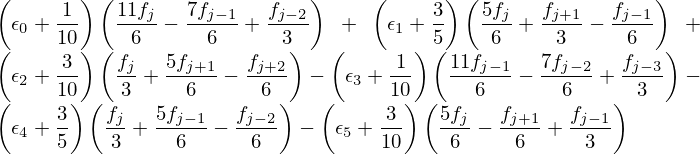

In [5]:
"""
linearized WENO method
"""
wenol = Data()
wenol.name = "linearized WENO"

ei = sp.symbols("\\epsilon_0:6",real=True)

def wenol_flux () :
  w0 = sp.Rational(1,10) + ei[0]
  w1 = sp.Rational(6,10) + ei[1]
  w2 = sp.Rational(3,10) + ei[2]
  
  w3 = sp.Rational(1,10) + ei[3]
  w4 = sp.Rational(6,10) + ei[4]
  w5 = sp.Rational(3,10) + ei[5]
  
  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({ei[0]:ei[3],ei[1]:ei[4],ei[2]:ei[5]})
  
  return fjp12 - fjm12

wenol.flux = wenol_flux()
del wenol_flux
display(wenol.flux)

Le flux de WENO linéarisé sans approximation fait intervenir les $\epsilon_i$ dont la contribution est difficilement quantifiable. On réécrit donc $\lambda^{W\ell} = \tilde{z} + M(\{\epsilon_i^\pm\}_i)$. Dans un premier temps il est plus simple d'étudier la partie linéaire $\tilde{z}$ de WENO en mettant toutes les valeurs des $\{\epsilon_i\}_{i=0,\dots,5}$ à zéro.

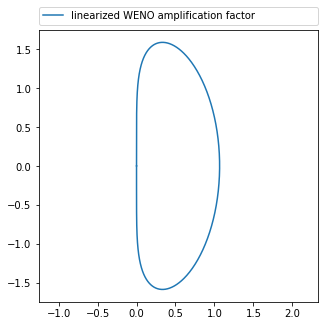

In [6]:
wenol.ztilde = Data()

wenol.ztilde.flux = wenol.flux.expand().subs([(e,0) for e in ei])
wenol.ztilde.func = sp.lambdify(phi,wenol.ztilde.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
wenol.ztilde.data = wenol.ztilde.func(data.phi)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(*reim(wenol.ztilde.data),label=wenol.name+" amplification factor")
plt.axis('equal')
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

On retrouve ainsi la courbe en *haricot* décrite dans [[M. Motamed and C. B. Macdonald and S. J. Ruuth (2010)]](https://doi.org/10.1007/s10915-010-9423-9) ou [[D. Ketcheson and C. B. Macdonald and S. J. Ruuth (2013)]](https://doi.org/10.1137/130906258).

On peut maintenant s'intéresser aux non linéarités $M(\{\epsilon_i^\pm\}_i)$

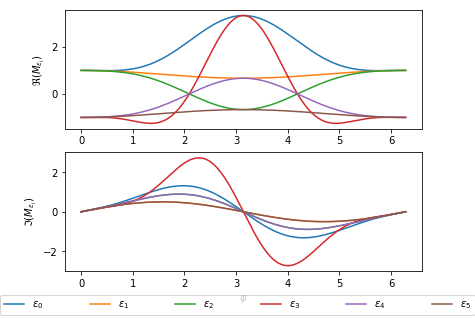

In [7]:
wenol.M = Data()

wenol.M.flux = (wenol.flux.expand() - wenol.ztilde.flux).collect(ei)
wenol.M.func = [ sp.lambdify(phi,arg.subs([(e,1) for e in ei]),'numpy')
                  for arg in wenol.M.flux.subs(symbols_to_vonNeumann(f_stencil)).args ]
wenol.M.data = [ fun(data.phi) for fun in wenol.M.func ]

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xlabel("$\\varphi$"); ax1.set_ylabel("$\\Re(M_{\\epsilon_i})$")
ax2.set_xlabel("$\\varphi$"); ax2.set_ylabel("$\\Im(M_{\\epsilon_i})$")

for i,dat in enumerate(wenol.M.data):
  ax1.plot(data.phi,dat.real,label="$\\epsilon_{}$".format(i))
  ax2.plot(data.phi,dat.imag,label="$\\epsilon_{}$".format(i))

handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc=(0.,0.01),ncol=len(wenol.M.data),mode="expand",borderaxespad=0.)
plt.show()

del fig,ax1,ax2,i,dat,handles,labels

En réalité la valeur des différentes composantes de $M$ nous importent peu. Ce qu'il faut remarquer est la forme général de chaque composante, prenons comme exemple la composante $\epsilon_0$ :

$$
  \begin{aligned}
    \Re \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Re}|\epsilon_0| \\
    \Im \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Im}|\epsilon_0|
  \end{aligned}
$$

avec $c_0^{\Re|\Im}$ des constantes positives. Dans [[Wang R. and Spiteri R. J. (2007)]](https://doi.org/10.1137/050637868), une estimation de $c_0^{\Re}=\frac{10}{3}$ est prise comme exemple. On majore ainsi toutes les composantes en $\epsilon_i$ de $M$, on se retrouve alors avec :

$$
  \begin{aligned}
    \left|\Re\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Re}\max_{0\leq m \leq 5}|\epsilon_m| \\
    \left|\Im\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Im}\max_{0\leq m \leq 5}|\epsilon_m|
  \end{aligned}
$$

avec $\Gamma^{\Re|\Im}$ des constantes postives ne dépendant que de la taille du *stencil* considéré. Cela permet de justifier $M = \mathcal{O}(\Delta x^2)$.

Le schéma WENO linéarisé correspond à l'approximation des poids $w_i^\pm=\gamma_i$, c'est-à-dire que les *indicators of smoothness* valent tous 1, ce qui se justifie avec une fonction suffisamment régulière. 

Dans un premier temps on vérifie l'ordre de la méthode, à partir du problème suivant :

$$
  \begin{cases}
    u_t + u+x = 0 \\
    u(t=0,x) = \cos(x)
  \end{cases}
$$

![Mesure de l'ordre numérique du schéma WENO linéarisé](img/order_WL.png)

On retrouve bien l'ordre 5 de la méthode WENO classique.

La linéarisation du schéma WENO suppose que la fonction est suffisamment régulière, nous allons observer son comportement face à une discontinuité en transportant à vitesse 1 une fonction créneau. La condition initiale est donnée par :

$$
  u(t=0,x) = \begin{cases}
    x \quad &\text{si $x \in [0,1]$}\\
    1 \quad &\text{si $x \in [1,4]$}\\
    0 \quad &\text{sinon}
  \end{cases}
$$


La simulation s'effectuant jusqu'au temps $T_f = 2\pi$ sur le domaine spatial périodique $[0,2\pi]$ avec $N_x = 100$ le nombre de points, et une condition CFL $\Delta t = 0.1\Delta x$. La solution exacte coïncide avec la condition initiale. La discrétisation en temps est un RK SSP(3,3).

![Oscillation du schéma WENO linéarisé en présence d'une discontinuité](misc/trp1d/img/discontinuity_weno_wenol.png)

On remarque que le schéma WENO linéarisé oscille à proximité d'une discontinuité, le schéma WENO classique quant à lui devient plus visqueux à l'aide des poids qui permettent d'effectuer une meilleure interpolation qu'une interpolation polynomiale de degré élevé induisant localement des oscillations.

On peut étudier la réponse du schéma WENO linéarisé à un cosinus. La méthode servant à approximer une dérivée, on peut vérifier ce comportement, connaissant la solution exacte.

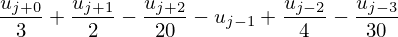

In [8]:
wenol.ztilde.flux.subs(symbols_to(f_stencil,lambda j,_:sp.symbols("u_{j%+d}"%j)))

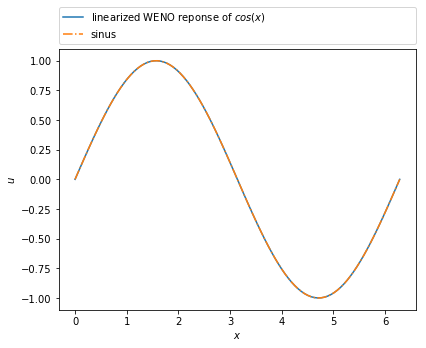

In [9]:
data.phi100 = np.linspace(0,2.0*np.pi,100)
data.deltaX = 2.*np.pi/data.phi100.size
wenol.ztilde.sinapprox = -sp.lambdify(x,wenol.ztilde.flux.subs(symbols_to(f_stencil,lambda j,_:sp.cos(x+j*dx))).subs(dx,data.deltaX)/data.deltaX,'numpy')(data.phi100)
plt.plot(data.phi100,wenol.ztilde.sinapprox,label=wenol.name+r" reponse of $cos(x)$")
plt.plot(data.phi100,np.sin(data.phi100),"-.",label="sinus")
plt.xlabel("$x$"); plt.ylabel("$u$")
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()

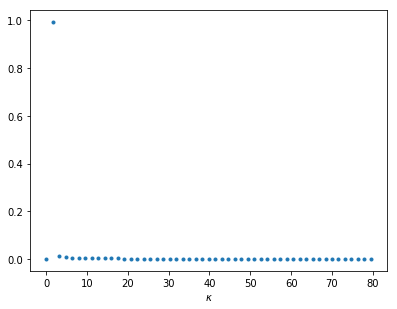

In [10]:
plt.plot( np.fft.rfftfreq(wenol.ztilde.sinapprox.size,2.*np.pi/data.phi.size) ,
         np.abs(np.fft.rfft(wenol.ztilde.sinapprox))*2./wenol.ztilde.sinapprox.size , "." )
plt.xlabel(r"$\kappa$")
plt.show()

Le résultat semble satisfaisant, regardons maintenant la différence entre les deux. L'erreur commise par WENO est de $10^{-8}$, avec un $\Delta x = \frac{2\pi}{100}$ (soit $\Delta x^{6}$ ce qui est attendu avec un schéma d'ordre 5).

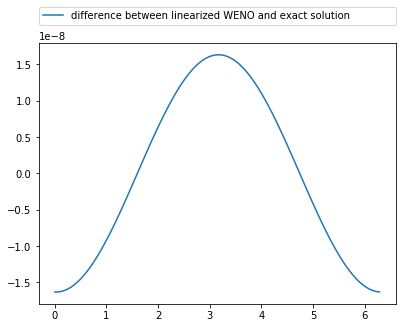

In [11]:
plt.plot(data.phi100,wenol.ztilde.sinapprox-np.sin(data.phi100),label="difference between "+wenol.name+" and exact solution")
plt.legend(loc=(0.,1.07),mode="expand",borderaxespad=0.)
plt.show()

In [12]:
(data.deltaX**6,max(wenol.ztilde.sinapprox-np.sin(data.phi100),key=lambda x:np.abs(x)))

### 1.1.2 Étude du schéma WENO5 non linéarisé

Puisque j'effectue mes calculs à l'aide de `sympy` et qu'il est facilement d'écrire automatiquement une fonction de $\phi$ du schéma WENO complet, j'étudie l'analyse de von Neumann du schéma WENO complet non linéarisé. Il n'est pas possible de justifier ce calcul par le calcul d'une transformée de Fourrier du schéma, on peut cependant indiquer que l'on choisit en entrée une fonction se décomposant en série de Fourrier et d'étudier l'amplification uniquement d'un mode avant d'étudier pour tout mode.

La justification donnée ici devrait permettre d'analyser par le même biais des alternatives au schéma WENO *standard* : WENO-JS, or, nous le verrons plus tard, l'analyse de s'effectue pas aussi bien.

In [13]:
"""
  complet WENO method
"""
weno = Data()
weno.name = "WENO"

epsilon = sp.symbols("\\epsilon",real=True,positive=True)

def weno_flux () :
  IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
  IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
  IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

  a0 = sp.Rational(1,10)*(1/(epsilon+IS0))**2
  a1 = sp.Rational(6,10)*(1/(epsilon+IS1))**2
  a2 = sp.Rational(3,10)*(1/(epsilon+IS2))**2
  
  s = a0 + a1 + a2
  w0 = a0 / s
  w1 = a1 / s
  w2 = a2 / s

  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  # we define fjm12 as fjp12 where f(j) is substitute by f(j-1)
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)
  
  return fjp12 - fjm12

weno.flux = weno_flux()
del weno_flux

Il est possible d'effectuer le même travail d'étude à la réponse d'une fonction connue pour observer l'approximation de la dérivée ainsi obtenue.

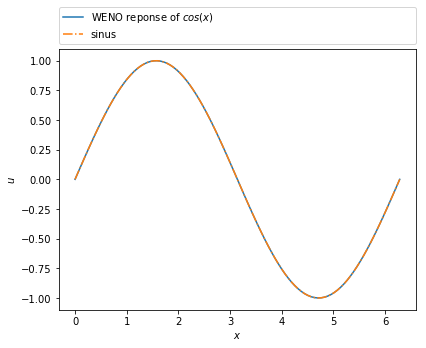

In [14]:
weno.sinapprox = sp.lambdify(x,-(weno.flux.subs(symbols_to(f_stencil,lambda j,_:sp.cos(x+j*dx)))).subs(epsilon,10**(-6)).subs(dx,data.deltaX)/data.deltaX,'numpy')(data.phi100)
plt.plot(data.phi100,weno.sinapprox,label=weno.name+r" reponse of $cos(x)$")
plt.plot(data.phi100,np.sin(data.phi100),"-.",label="sinus")
plt.xlabel("$x$"); plt.ylabel("$u$")
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()

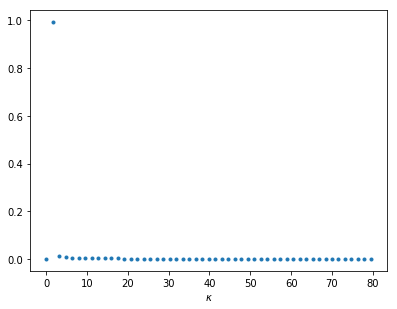

In [15]:
plt.plot( np.fft.rfftfreq(weno.sinapprox.size,2.*np.pi/data.phi.size) ,
         np.abs(np.fft.rfft(weno.sinapprox))*2./weno.sinapprox.size , '.' )
plt.xlabel(r"$\kappa$")
plt.show()

On peut maintenant tracer la différence entre les coefficients de Fourier des 2 résultats, entre WENO et WENO linéarisé.

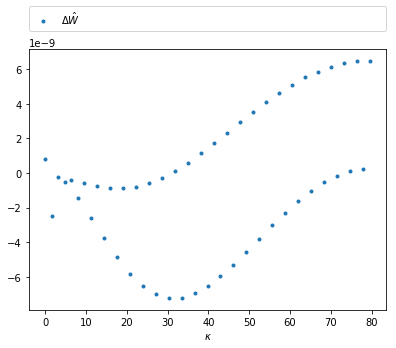

In [16]:
plt.plot( np.fft.rfftfreq(weno.sinapprox.size,2.*np.pi/data.phi.size) ,
          np.abs(np.fft.rfft(weno.sinapprox))*2./weno.sinapprox.size - np.abs(np.fft.rfft(wenol.ztilde.sinapprox))*2./wenol.ztilde.sinapprox.size ,
         '.' , label=r"$\Delta \hat{W}$")
plt.xlabel(r"$\kappa$")
plt.legend(loc=(0.,1.07),mode="expand",borderaxespad=0.)
plt.show()

In [17]:
(data.deltaX**6,max(weno.sinapprox-np.sin(data.phi100),key=lambda x:np.abs(x)))

## 1.2 Méthodes WENO modifiées

Il existe différentes méthodes de calcul des poids du schéma WENO, qui ont été listées et comparées [ici](https://github.com/wme7/WENO5-X) par Manuel A. Diaz. Nous étudirons ici leur différents coefficients d'amplification.

La différence réside uniquement dans l'estimation des poids, les indicateurs de continuité $\beta_i$ ainsi que les coefficients $\gamma_i$ restent identique.

| Méthode     | Calcul des poids $w_i$ | Parmètres |
|-------------|------------------------|-----------|
| **WENO-JS** | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-6}$                              |
| **WENO-M**  | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \\ g_i &\gets w_i\left(\frac{\gamma_i + \gamma_i^2 - 3w_i\gamma_i + w_i^2}{\gamma_i^2+w_i(1-2\gamma_i)}\right) \\ w_i &\gets \frac{g_i}{\sum g_k} \end{aligned}$$ | $\epsilon = 10^{-6}$ |
| **WENO-Z**  | $$\begin{aligned}\alpha_i &\gets \gamma_i\left(1+\frac{\tau_5}{\epsilon + \beta_i}\right) \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-40}$, $\tau_5 = |\beta_0-\beta_2|$ |

La méthode WENO-JS est la méthode WENO *classique* de Jiang et Shu et sert juste pour la comparaison avec WENO-M (WENO avec une fonction de *mappage*) et WENO-Z. L'objectif de ces méthodes est de minimiser la perte d'ordre à l'approche d'une discontinuité, donc d'approter moins de viscosité numérique.

### 1.2.1 WENO-M

La méthode WENO-M fonctionne à l'aide d'une fonction dit de *mappage* : $g_i$. Cette fonction est définie par :

$$
  g_i : w\mapsto w\left(\frac{\gamma_i+\gamma_i^2-3w\gamma_i+w^2}{\gamma_i^2 + w(1-2\gamma_i)}\right)
$$

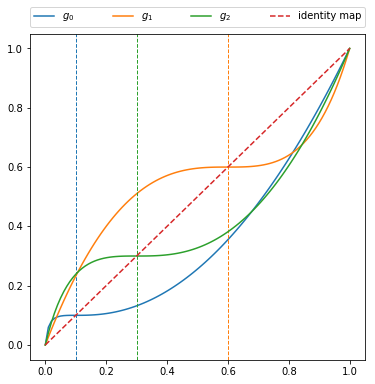

In [18]:
w,gamma_i = sp.symbols("w \\gamma_i",real=True)
g = w*(gamma_i+gamma_i**2-3*w*gamma_i+w**2)/(gamma_i**2+w*(1-2*gamma_i))

plt.rcParams['figure.figsize'] = [6,6]
linW = np.linspace(0,1.0,100)
for i,gi in enumerate([sp.Rational(1,10),sp.Rational(6,10),sp.Rational(3,10)]) :
  plt.plot(linW,sp.lambdify(w,g.subs(gamma_i,gi),'numpy')(linW),label="$g_{}$".format(i),color=default.palette[i])
  plt.axvline(gi,color=default.palette[i],linestyle='--',linewidth=1.)
plt.plot(linW,linW,"--",label="identity map",color=default.palette[3])
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.show()

display(sp.Eq( sp.symbols("g_i'(\\gamma_i)") , g.diff(w).subs(w,gamma_i).simplify() ))
del w,gamma_i,g,linW,i,gi
plt.rcParams['figure.figsize'] = default.figsize

Les fonctions $g_i$ n'ont besoin d'être définie que sur l'intervalle $[0,1]$ puisque les poids d'une méthode WENO vérifient $\sum_k w_k=1$ et $w_k\leq0\,\forall k$. Les points fixes de la fonction de *mappage* $g_i$ sont les 2 valeurs triviales 0 et 1, ainsi que $\gamma_i$ (la valeur linéarisé du poids). La fonction $g_i$ sera évaluée en $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$, ce qui nous intéresse est donc son évaluation en des points proches de $\gamma_i$. On remarque que la dérivée de $g_i$ est nulle (donc un plateau) en $\gamma_i$ et que $g_i(\gamma_i) = \gamma_i$, cela permet de forcer une certaine linéarisation des poids, sans pour autant faire apparaître des oscillations.

Pour une étude plus approfondie de cette méthode avec l'analyse de *von Neumann*, on peut remarquer que la linéarisation des poids donne toujours $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$. L'analyse qui en suit sera identique.

### 1.2.2 WENO-Z

La méthode WENO-Z consiste à minimiser la baisse d'ordre à l'approche d'une discontinuité. Dans le cadre de la simulation de plasmas, nous savons que nos fonctions de distribution seront continue, l'ordre élevé est nécessaire pour capturer correctement les forts gradients.

Pour l'analyse de stabilité, la linéarisation des poids donne aussi $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$, l'analyse de *von Neumann* du schéma linéarisé reste donc la même.

## 1.3 BWENO

[[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) est proposé une modification du schéma WENO plus intéressante pour l'étude de l'équation de Vlasov. Nous étudierons ici la présentation effectuée dans la seconde publication. Dans la continuation des schémas d'ordre élevé en espace, nous nous intéresserons au schéma BWENO d'ordre 6 présenté.

L'idée de ce schéma reste similaire à celle du WENO dans l'esprit du calcul de poids non linéaire s'adaptant aux irrégularités de la fonction. Le nombre de poids est en revanche limité à 2, et ceux-ci ne sont plus des polynôme en $\left(f_{i+k}^4\right)_{k\in [\![ -3,3 ]\!]}$ mais seulement de degré 2 : $\left(f_{i+k}^2\right)_{k\in [\![ -3,3 ]\!]}$. Cette diminution du nombre de multiplication peut rendre ce schéma compétitif au niveau du temps de calcul. Les solutions attendues dans la simulation de plasmas avec l'équation de Vlasov-Poisson sont régulières, l'ordre élevé des schémas sert à capturer les forts gradients de la solution qui peuvent apparaître lors de la filamentation.

Le flux $\hat{u}^{(B)}_{j-\frac{1}{2}}$ du schéma BWENO d'ordre $p$ s'obtient par l'addition pondéré de 2 interpolations $L$ et $R$, d'ordre $p-1$. Nous ne nous intéresserons ici qu'à la méthode d'ordre 6, nous nous abstiendrons donc d'indiquer l'ordre.

$$
  \hat{u}^{(B)}_{j-\frac{1}{2}} = w^{(L)}_{j-\frac{1}{2}}u^{(L)}_{j-\frac{1}{2}} + w^{(R)}_{j-\frac{1}{2}}u^{(R)}_{j-\frac{1}{2}}
$$

L'écriture du schéma commence par l'estimation des indicateurs de continuité :

$$
  \begin{aligned}
      \beta(u_i) = (\Delta^1_4u_i)\left( (\Delta^1_4u_i) + (\Delta^2_4u_i) + \frac{1}{3}(\Delta^3_2u_i) + \frac{1}{12}(\Delta^4_2u_i) \right) \\
      + (\Delta^2_4u_i)\left( \frac{4}{3}(\Delta^2_4u_i) + \frac{5}{4}(\Delta^3_2u_i) + \frac{2}{5}(\Delta^4_2u_i) \right) \\
      + (\Delta^3_2u_i)\left( \frac{83}{60}(\Delta^3_2u_i) + \frac{23}{18}(\Delta^4_2u_i) \right) \\
      + \frac{437}{315}(\Delta^4_2u_i)^2
  \end{aligned}
$$

où les $(\Delta^d_pu_i)$ sont des approximations d'ordre $p$ de la dérivée d'ordre $d$ :

$$
  \begin{aligned}
    (\Delta^1_4u_i) &= \frac{1}{12}\left( -u_{j+2} +  8u_{j+1}           -  8u_{j-1} + u_{j-2} \right) \\
    (\Delta^2_4u_i) &= \frac{1}{12}\left( -u_{j+2} + 16u_{j+1} - 30u_{j} + 16u_{j-1} - u_{j-2} \right) \\
    (\Delta^3_2u_i) &=  \frac{1}{2}\left(  u_{j+2} -  2u_{j+1}           +  2u_{j-1} - u_{j-2} \right) \\
    (\Delta^4_2u_i) &=             \left(  u_{j+2} -  4u_{j+1} +  6u_{j} -  4u_{j-1} + u_{j-2} \right) \\
  \end{aligned}
$$

Nous prendrons $\beta^{(L)}_{j-\frac{1}{2}} = \beta(u_{j-1})$ et $\beta^{(R)}_{j-\frac{1}{2}} = \beta(u_j)$ comme indicateurs de continuité respectivement à gauche et à droite.

Les 2 poids non normalisés sont :

$$
  a^{(\Xi)}_{j-\frac{1}{2}} = \frac{d}{\epsilon + \beta^{(\Xi)}_{j-\frac{1}{2}}}
$$

où $\Xi = L,R$, $d=\frac{1}{2}$ et $\epsilon$ un paramètre pour éviter la nullité du dénominateur. Ce qui nous donne les poids :

$$
  \tilde{w}^{(\Xi)}_{j-\frac{1}{2}} = \frac{a^{(\Xi)}_{j-\frac{1}{2}}}{a^{(L)}_{j-\frac{1}{2}}+a^{(R)}_{j-\frac{1}{2}}}
$$

Les poids sont ensuites classé selon la direction, ici pour une vitesse positive (dans l'étude du schéma nous prendrons $v=1$) :

$$
  \begin{cases}
    w^{(L)} = \max\left(\tilde{w}^{(L)}_{j-\frac{1}{2}},\tilde{w}^{(R)}_{j-\frac{1}{2}}\right) \\
    w^{(R)} = \min\left(\tilde{w}^{(L)}_{j-\frac{1}{2}},\tilde{w}^{(R)}_{j-\frac{1}{2}}\right)
  \end{cases}
$$

Les flux à gauche et à droite sont maintenant calculés comme suit :

$$
  \begin{cases}
    \hat{u}^{(L)}_{j-\frac{1}{2}} = \frac{1}{60}\left( -3u_{j+1}+27u_{j}+47u_{j-1} -13u_{j-2} + 2u_{j-3} \right) \\
    \hat{u}^{(R)}_{j-\frac{1}{2}} = \frac{1}{60}\left( 2u_{j+2}-13u_{j+1}+47u_{j}+27u_{j-1}-3u_{j-2}  \right) \\
  \end{cases}
$$

On peut enfin calculer une approximation de $\partial_x u$ à l'aide du flux de BWENO par :

$$
  \partial_x u \approx \frac{1}{\Delta x}\left( \hat{u}^{(B)}_{j+\frac{1}{2}} - \hat{u}^{(B)}_{j-\frac{1}{2}} \right)
$$

> Pour l'étude du schéma BWENO, l'article [[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) propose une linéarisation du schéma en prenant les poids $w^L$, $w^R$ égaux à différents couples de nombres positifs vérifiant que $w^L+w^R=1$, ainsi est tracé le coefficient d'amplification pour $w^L=1,\frac{3}{4},\frac{1}{2}$. En effet différents éléments empêche facilement d'écrire les poids sous la forme $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$ comme les précédentes modifications du schéma WENO.

In [19]:
def bweno_flux ( wl=None , wr=None ) :
  """
    return expression of all BWENO scheme
    it could be linearized with optional special weight `wl` and `wr`. By default it is not linearized,
    if only `wl` is done then `wr = 1-wl`.
  """
  
  def beta ( k ) :
    """
      Indicator of smootheness of BWENO method
    """
    D14uj = sp.Rational(1,12)*( -f(k+2) +  8*f(k+1)             -  8*f(k-1) + f(k-2) )
    D24uj = sp.Rational(1,12)*( -f(k+2) + 16*f(k+1) - 30*f(k+0) + 16*f(k-1) - f(k-2) )
    D32uj =  sp.Rational(1,2)*(  f(k+2) -  2*f(k+1)             +  2*f(k-1) - f(k-2) )
    D42uj =                   (  f(k+2) -  4*f(k+1) +  6*f(k+0) -  4*f(k-1) + f(k-2) )

    return ( D14uj*( D14uj + D24uj + sp.Rational(1,3)*D32uj + sp.Rational(1,12)*D42uj )
           + D24uj*( sp.Rational(4,3)*D24uj + sp.Rational(5,4)*D32uj + sp.Rational(2,5)*D42uj )
           + D32uj*( sp.Rational(83,60)*D32uj + sp.Rational(23,18)*D42uj )
           + sp.Rational(437,315)*D42uj*D42uj )
  
  if wl==None :
    b5Rjm12 = beta(0)
    b5Ljm12 = beta(-1)

    a5Ljm12 = sp.Rational(1,2)/( epsilon + b5Ljm12 )
    a5Rjm12 = sp.Rational(1,2)/( epsilon + b5Rjm12 )
    
    wt5Ljm12 = a5Ljm12 / ( a5Ljm12 + a5Rjm12 )
    wt5Rjm12 = a5Rjm12 / ( a5Ljm12 + a5Rjm12 )
    
    w5Ljm12 = sp.Max(wt5Ljm12,wt5Rjm12)
    w5Rjm12 = sp.Min(wt5Ljm12,wt5Rjm12)
  else :
    w5Ljm12 = wl
    if wr == None:
      w5Rjm12 = 1-wl
    else:
      w5Rjm12 = wr
  
  u5Ljm12 = sp.Rational(1,60)*( -3*f(+1) + 27*f(+0) + 47*f(-1) - 13*f(-2) + 2*f(-3) )
  u5Rjm12 = sp.Rational(1,60)*(  2*f(+2) - 13*f(+1) + 47*f(+0) + 27*f(-1) - 3*f(-2) )
  
  u6Bjm12 = w5Ljm12*u5Ljm12 + w5Rjm12*u5Rjm12
  u6Bjp12 = u6Bjm12.subs(symbols_to(f_stencil, lambda j,_:f(j+1)),simultaneous=True)
  return u6Bjp12-u6Bjm12

bweno = Data()
bweno.name = "BWENO"
bweno.flux = bweno_flux
del bweno_flux

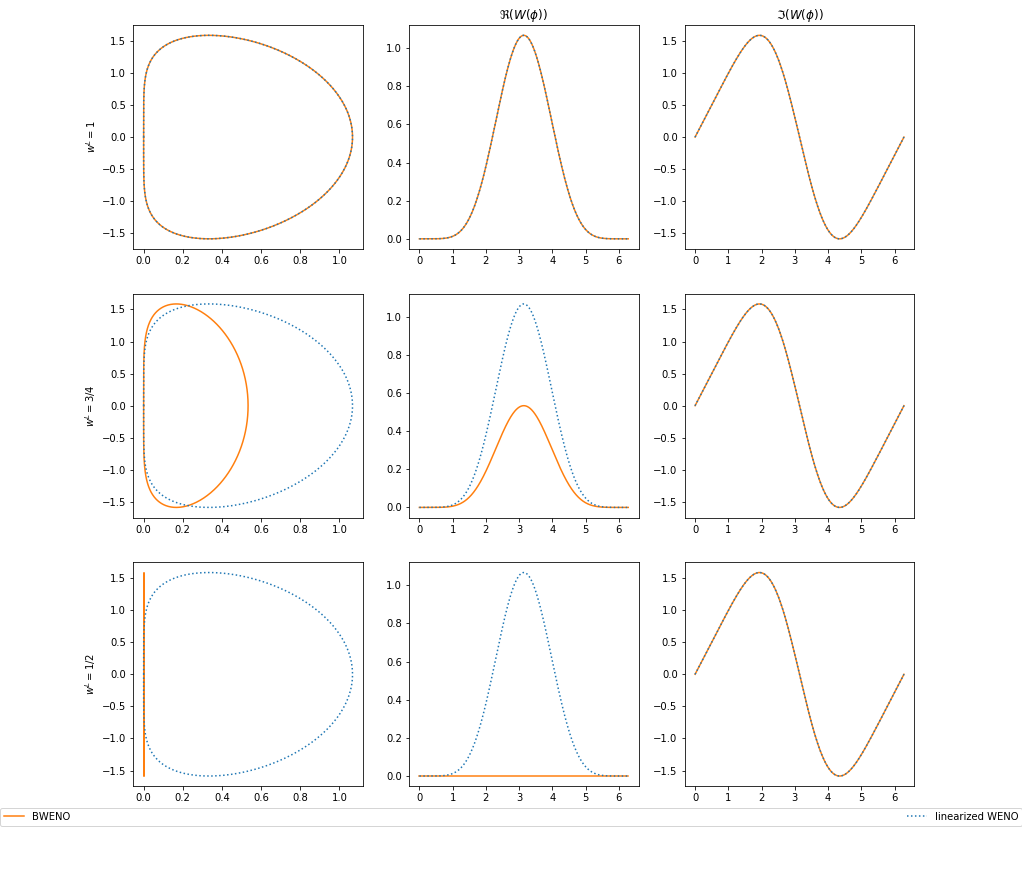

In [20]:
bweno.wl = Data()
bweno.wl.values = (1,sp.Rational(3,4),sp.Rational(1,2))
bweno.wl.func = [ sp.lambdify(phi,bweno.flux(wl).subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-8)),'numpy') for wl in bweno.wl.values ]
bweno.wl.data = [ f(data.phi) for f in bweno.wl.func ]

fig, ax = plt.subplots(nrows=len(bweno.wl.values),ncols=3,figsize=(14,14))

wenol.ztilde.re,wenol.ztilde.im = reim(wenol.ztilde.data)

for i,wl in enumerate(bweno.wl.values) :
  tmp_re,tmp_im = reim(bweno.wl.data[i])
  ax[i][0].plot(tmp_re,tmp_im,label=bweno.name,color=default.palette[1])
  ax[i][0].plot(wenol.ztilde.re,wenol.ztilde.im,':',label=wenol.name,color=default.palette[0])
  ax[i][0].set_ylabel("$w^L = {}$".format(wl))
  
  ax[i][1].plot(data.phi,tmp_re,label=bweno.name,color=default.palette[1])
  ax[i][1].plot(data.phi,wenol.ztilde.re,':',label=wenol.name,color=default.palette[0])
  
  ax[i][2].plot(data.phi,tmp_im,label=bweno.name,color=default.palette[1])
  ax[i][2].plot(data.phi,wenol.ztilde.im,':',label=wenol.name,color=default.palette[0])

ax[0][1].title.set_text("$\\Re(W(\phi))$")
ax[0][2].title.set_text("$\\Im(W(\phi))$")
handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc=(0.,0.05),ncol=2,mode="expand",borderaxespad=0.)
plt.show()

del fig,ax,i,wl,handles,labels

En linéarisant les poids ($w^L=1,\frac{3}{4},\frac{1}{2}$), on remarque un comportement similaire à celui du schéma WENO linéarisé (qui coïncide parfaitement pour $w^L=1$, $w^R=0$), avec un comportement dégénéré dans le cas centré $w^L = w^R = \frac{1}{2}$ (transport pur sans diffusion). La partie imaginaire, même dans le cas non linéarisé, la méthode BWENO reproduit le même comportement que la méthode WENO linéarisée.

On peut vérifier l'ordre du schéma. Pour cela on calcule l'erreur sur une advection à vitesse 1 :

$$
  \begin{cases}
    u_t + u_x = 0 \\
    u^0(x) = u(t=0,x) = \cos(2x)
  \end{cases}
$$

jusqu'au temps final $T_f = \pi$ (le mode 2 de la condition initiale permet d'avoir $u(t=T_f,x)=u^0(x)$), avec $m=10,20,\dots,200$ points, $\Delta x = \frac{2\pi}{m}$, on prendra $\Delta t = 0.1\frac{\Delta x}{200}$. La discrétisation en temps s'effectue avec RK SPP(3,3).

Il serait envisageable de prendre un $\Delta t$ plus grand, mais cela permet de minimiser l'erreur en temps pour ne considérer que l'erreur en espace du schéma.

![Ordre du schéma BWENO](misc/trp1d/img/order_bweno.png)

[[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) annonce un ordre 6, celui-ci est sans doute plus visible avec la norme $L^{\infty}$ qu'avec la norme $L^1$, la norme $L^2$ n'a pas été calculé dans ce cas.

Nous étudions également son comportement face à une discontinuité avec le même cas test qu'avec le schéma WENO linéarisé. Il s'agit essentiellement d'étudier son comportement face à une discontinuité. Comme précédemment, nous conservons qu'une simple équation de transport linéaire à vitesse 1. La condition initiale est donnée par :

$$
  u(t=0,x) = \begin{cases}
    x \quad &\text{si $x \in [0,1]$}\\
    1 \quad &\text{si $x \in [1,4]$}\\
    0 \quad &\text{sinon}
  \end{cases}
$$

La simulation s'effectuant jusqu'au temps $T_f = 2\pi$ sur le domaine spatial périodique $[0,2\pi]$ avec $N_x = 100$ le nombre de points, et une condition CFL $\Delta t = 0.1\Delta x$. La solution exacte coïncide avec la condition initiale. La discrétisation en temps est un RK SSP(3,3).

![Oscillation du schéma BWENO en présence d'une discontinuité](misc/trp1d/img/discontinuity_weno_wenol_bweno.png)

On remarque que le schéma BWENO oscille à proximité d'une discontinuité, avec une norme $L^{\infty}$ légèrement supérieure à la méthode WENO linéarisée.

## 1.4 WENO3

Après avoir présenté les méthodes WENO dites *classiques* que sont la méthode WENO d'ordre 5 et ses dérivées, attardons nous un peu sur la méthode WENO3, étrangement moins étudiée. La méthode est beaucoup plus succinte mais se présente de manière similaire avec un calcul d'indicateurs de continuité, puis de poids que l'on normalise, et enfin le calcul du flux.

Les indicateurs de continuités $\beta_0$ et $\beta_1$ se calculent comme suit :

$$
  \begin{aligned}
    \beta_0^+ &= \left(-f_{i-1}^+ + f_{i}^+\right)^2\\
    \beta_1^+ &= \left(-f_{i}^+ + f_{i+1}^+\right)^2
  \end{aligned}
$$

$$
  \begin{aligned}
    \beta_0^- &= \left(-f_{i+2}^- + f_{i+1}^-\right)^2\\
    \beta_1^- &= \left(-f_{i+1}^- + f_{i}^-\right)^2
  \end{aligned}
$$

Ensuite les poids :

$$
  \alpha_i^\pm = \frac{\gamma_i}{(\epsilon+\beta_i^\pm)^2}
$$

avec $\gamma_0 = \frac{1}{3}$ et $\gamma_1=\frac{2}{3}$ ; poids que l'on normalisent :

$$
  w_i^\pm = \frac{w_i}{w_0+w_1}
$$

Enfin le flux, définit par :

$$
  f_{i+\frac{1}{2}}^+ = w_0^+\left(-\frac{1}{2}f_{i-1}^+ + \frac{3}{2}f_i^+\right) + w_1^+\left(\frac{1}{2}f_i^++\frac{1}{2}f_{i+1}^+\right)
$$

$$
  f_{i+\frac{1}{2}}^- = w_0^-\left(-\frac{1}{2}f_{i+2}^- + \frac{3}{2}f_{i+1}^-\right) + w_1^-\left(\frac{1}{2}f_{i+1}^-+\frac{1}{2}f_{i}^-\right)
$$

La méthode WENO3 prend la forme finale :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}\left[ \left(f_{j+\frac{1}{2}}^+ - f_{j-\frac{1}{2}}^+ \right) + \left(f_{j+\frac{1}{2}}^- - f_{j-\frac{1}{2}}^- \right) \right]
$$

Pour l'étude de la stabilité nous ne prendrons que le cas $f^+(u) = u$ et $f^-(u) =0$

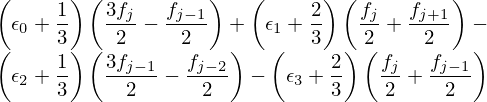

In [21]:
"""
linearized WENO method
"""
weno3l = Data()

def weno3l_flux () :
  w0 = sp.Rational(1,3) + ei[0]
  w1 = sp.Rational(2,3) + ei[1]
  
  w2 = sp.Rational(1,3) + ei[2]
  w3 = sp.Rational(2,3) + ei[3]
  
  fjp12 = ( w0*( -sp.Rational(1,2)*f(-1) + sp.Rational(3,2)*f(+0) )
          + w1*(  sp.Rational(1,2)*f(+0) + sp.Rational(1,2)*f(+1) ) )
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({ei[0]:ei[2],ei[1]:ei[3]})
  
  return fjp12 - fjm12

weno3l.flux = weno3l_flux()
del weno3l_flux
display(weno3l.flux)

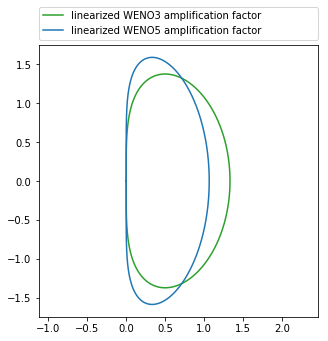

In [22]:
weno3l.ztilde = Data()

weno3l.ztilde.flux = weno3l.flux.expand().subs([(e,0) for e in ei])
weno3l.ztilde.func = sp.lambdify(phi,weno3l.ztilde.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
weno3l.ztilde.data = weno3l.ztilde.func(data.phi)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(*reim(weno3l.ztilde.data),label="linearized WENO3 amplification factor",color=default.palette[2])
plt.plot(*reim(wenol.ztilde.data),label="linearized WENO5 amplification factor",color=default.palette[0])
plt.axis('equal')
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Comme indiqué dans la littérature, la méthode WENO3 diffuse plus que son équivalent d'ordre 5, cela se remarque par une plus grande partie imaginaire.

# 2. Discrétisation en temps

## 2.1 Méthodes Runge-Kutta explicites

Les schémas Runge-Kutta sont souvent utilisés dans le domaine des EDP pour résoudre la discrétisation en temps, conforme à cette tradition c'est ce que nous allons effectuer. Nous cherchons quel est l'ordre minimale $n$ ainsi que le nombre d'étages $s$ pour stabiliser le couple RK($s$,$n$)-WENO5, ou celui qui permettra d'obtenir la plus grande CFL avec le minimum de coût numérique.

On s'intéresse ici à la fonction de stabilité d'un schéma RK. On sait que le polynôme caractéristique d'un schéma RK($n$,$n$) est une troncature de la série entière de l'exponentielle (auquel peut s'ajouter des termes de degré plus élevé si le nombre d'étage $s$ est supérieur à l'ordre de la méthode $n$), donc de la forme :

$$
  p_{(n,n)}(z) = \sum_{k=0}^n \frac{z^k}{k!}
$$

Il est ensuite nécessaire de tracer la courbe d'équation $|p_{(n,n)}(z)| = 1$, pour cela Miguel m'a proposé de résoudre dans un premier temps l'équation :

$$
  p_{(n,n)}(z) = e^{i\theta}
$$

à $\theta$ fixé, on a ainsi $n$ solutions $(b_0(\theta),\dots,b_n(\theta))$. Puis ensuite faire varier $\theta \in [0,2\pi[$. On obtient ainsi $n$ courbes paramétriques que l'on peut tracer sans trop de problèmes.

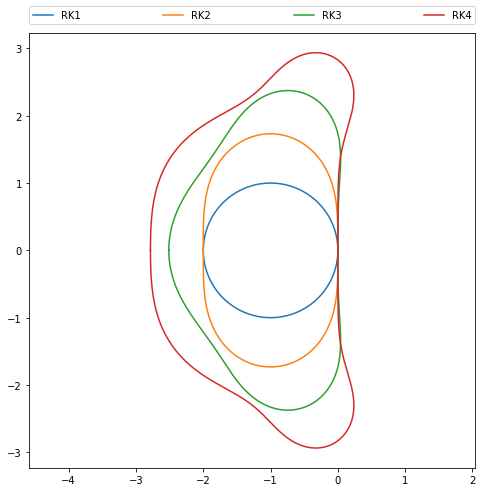

In [23]:
import math

def poly_carac(N):
  """
    return trunc developpement of exponential function to the order `N`
  """
  return sum([ sp.Rational(1,(math.factorial(n)))*z**n for n in range(N+1) ])

def rk_set(N):
  """
    return a list of points where modulus of caracteristic polynomial is equal to 1
    this function compute this set of points with a polynomial solver in C, so it
    doesn't work for `N > 4`.
  """
  theta = sp.symbols("\\theta",real=True)
  p = poly_carac(N)
  bset = sp.solveset(sp.Eq(p,sp.exp(I*theta)),z)
  
  bcurve = []
  for b in [ sp.lambdify(theta,b,'numpy') for b in bset ] :
    tmp = b(data.phi)
    bcurve.extend(tmp.tolist())
  return np.array(sorted(bcurve,key=lambda z:np.angle(z+1)))

plt.rcParams['figure.figsize'] = [8,8]
plt.plot(*reim(rk_set(1)),label="RK1")
plt.plot(*reim(rk_set(2)),label="RK2")
plt.plot(*reim(rk_set(3)),label="RK3")
plt.plot(*reim(rk_set(4)),label="RK4")
plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Ces fonctions de stabilités ne sont que celles d'une méthode RK($n$,$n$), avec $n<5$ pour pouvoir résoudre de façon exacte les racines du polynôme. Il est possible de tracer directement un contour avec `matplotlib` à l'aide de la fonction `plt.contour`. On peut ainsi obtenir, en un temps relativement court, un ensemble de points. En plus de tracer cet ensemble de points, il est également possible de récupérer la liste des points tracés, à l'aide de l'attribut `allsegs` de la classe `matplotlib.contour.QuadContourSet`.

> **Attention :** `matplotlib` permet de récupérer la liste des points tracés, si le domaine d'étude est trop resteint, seuls les points se trouvant dans ce domaine seront listés. Comme son nom l'indique l'attribut `allsegs` renvoie des listes de points qui forment les segements tracés, par conséquent il est possible de récupérer chaque sous ensemble connexe (ce qui permet d'exclure l'étude des non-connexités des méthodes Runge-Kutta avec plus d'étages.

In [24]:
def contour ( expr , z , Ir=(-6.,3.,500) , Ii=(-6.,6.,500) , **kwargs):
  """
    draw a contour of a C expression `expr` on `z` parameter on `Ir`x`Ii` domain
  """
  x,y = sp.symbols("x y",real=True)
  f = sp.lambdify((x, y), expr.subs(z,x+I*y),'numpy')
  
  a = np.linspace(*Ir)
  b = np.linspace(*Ii)
  X, Y = np.meshgrid(a, b)
  try:
    lab = kwargs.pop("label")
  except:
    lab = ""
  try:
    c = kwargs["colors"]
  except:
    c = default.palette[0]
  if len(lab) > 0 :
    plt.plot([0],[0],label=lab,color=c)
  return plt.contour(X,Y, np.real(f(X,Y)),**kwargs)

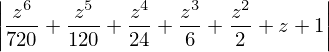

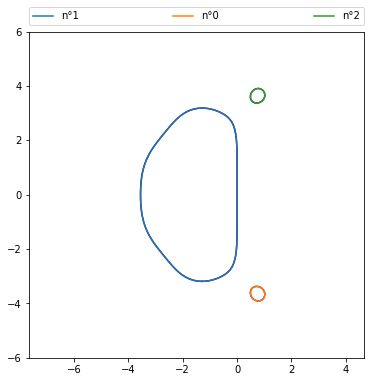

nombre de points dans chaque sous-domaine :
105 927 105


In [25]:
R = sp.Abs(poly_carac(6))

plt.rcParams['figure.figsize'] = [6,6]

dat = contour(R,z,(-6.,3.,500),(-6.,6.,500), levels=[1.]).allsegs

display(R)
plt.plot(dat[0][1][:,0],dat[0][1][:,1],label="n°{}".format(1))
plt.plot(dat[0][0][:,0],dat[0][0][:,1],label="n°{}".format(0))
plt.plot(dat[0][2][:,0],dat[0][2][:,1],label="n°{}".format(2))
plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

# comparaison du nombre de point dans la frontière de chaque sous domaine
print("nombre de points dans chaque sous-domaine :")
print(len(dat[0][0][:]),len(dat[0][1][:]),len(dat[0][2][:]))

del R,dat

> L'astuce trouvé pour obtenir le domaine principal et qui sera utilisé par la suite, est de liste les sous domaine `allsegs` et de les trier par nombre de points. Le domaine *principal* qui permettra de stabiliser un schéma type WENO, ou méthode centré par exemple, est (quasi-systématiquement) celui ayant le plus de points.
> 
> **Cette méthode n'a rien de mathématique, juste une constatation empirique**.

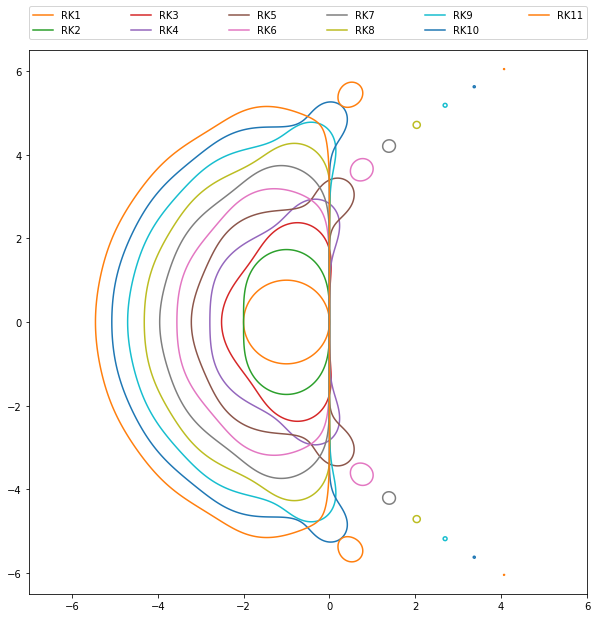

In [26]:
plt.rcParams['figure.figsize'] = [10,10]

for n in range(1,12):
  print(n,end="\r")
  R = sp.Abs(poly_carac(n))
  contour(R,z,(-7,6,1000),(-6.5,6.5,1000), levels=[1.],colors=default.palette[n%len(default.palette)],label="RK{}".format(n))
print(" "*len(str(n)))
plt.legend(loc=(0.,1.02),ncol=6,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del n,R

> Joackim m'a fait remarquer que les *bras* contiennent une infinité de *bulles* de plus en plus petites (on voit ceci pour la petite *bulle* orange à l'extrémité du *bras* qui apparait seulement lorsque on raffine le domaine). On peut même conjecturer que la forme des bras sont des paraboles. On voit la naissance de la deuxième paire de *bras* avec les grosses *bulles* oranges.
>
> L'étude de ces non-connexités des domaines de stabilités ne semblent pas présenter d'intérêt pour ce que l'on fait. De plus ces domaines ne correspondent pas à la stabilité d'une méthode connue. En effet il n'y a pas de méthode Runge-Kutta d'ordre $n$ à $n$ étages connues pour $n\geq 5$.

L'étude de ces méthodes RK($n$,$n$) avec $n>4$ n'est pas pertinante puisqu'il n'existe pas de méthode Runge-Kutta d'ordre 5 à 5 étages, le problème est similaire pour les méthodes d'ordre supérieur. À partir de maintenant nous allons étudier ces méthodes à partir de leur écriture sous forme de schéma ou de tableau de Butcher. Par la suite, le tableau de Butcher sera plus pratique pour tirer plus d'information comme le schéma de Lawson induit.

### 2.1.1 Obtention de la fonction de stabilité depuis un schéma numérique

Les calculs effectués pour l'instant ne s'appliquent que pour un RK($n$,$n$) à $n$ étages. Considérons maintenant un RK($s$,$n$) à $s$ étages ($s\geq n$ car la méthode est explicite). Il est nécessaire de calculer sa fonction de stabilité (qui est un polynôme dans le cadre des méthodes explicites).

L'obtention de la fonction de stabilité s'effectue avec une fonction $L$ linéaire, ainsi pour un problème du type :

$$
  \frac{\mathrm{d}u}{\mathrm{d}t} = L(t,u)
$$

on effectue la substitution :

* $L(t,u) \rightarrow \lambda u$ (on linéarise $L$ sur le plan complexe à l'aide d'une variable $\lambda$, dans notre cas $\lambda$ représente le coefficient d'amplification de notre discrétisation en espace)
* $\lambda \Delta t \rightarrow z$ (on veut étudier le coefficient d'amplification donné par le produit $\lambda \Delta t$)

Nous étudions ainsi un schéma RK(4,3) :

$$
  \begin{aligned}
    u^{(1)} &= u^n + \frac{1}{2}\Delta t L(t^n,u^n) \\
    u^{(2)} &= u^{(1)} + \frac{1}{2}\Delta t L(t^n+\frac{1}{2}\Delta t,u^{(1)}) \\
    u^{(3)} &= \frac{2}{3}u^n + \frac{1}{3}u^{(2)} + \frac{1}{6}\Delta t L(t^n+\Delta t,u^{(2)}) \\
    u^{n+1} &= u^{(3)} + \frac{1}{2}\Delta t L(t^n+\frac{1}{2}\Delta t,u^{(3)})
  \end{aligned}
$$

La méthode sera dite de *Shu-Osher* si elle n'effectue qu'un seul appel à la fonction $L$ par étage, on verra plus tard que pour un tableau de Butcher donné, il est facilement possible de *shuosheriser* la méthode.

In [27]:
un = sp.symbols("u_n")

lamb = sp.symbols("\\lambda",complex=True)
L = sp.Function("L")

def name_stages ( v_s , s ) :
  """
    return a list of symbols for each stages of a RK(`s`,$n$) method on a `v_s (str)` name function
    for example :
    ```
      name_stages("u",3) #-> should return list of symbols "[u^n, u^{(1)}, u^{(2)}, u^{n+1}]"
    ```
  """
  vs = [ sp.symbols(v_s+"^n") ]
  vs.extend([ sp.symbols(v_s+"^{(%i)}"%j) for j in range(1,s) ])
  vs.append(sp.symbols(v_s+"^{n+1}"))
  return vs

class rk_scheme (object) :
  ui = name_stages("u",42)
  def __init__ (self,s,label="") :
    self.s = s
    self.stages = [0 for x in range(s)]
    self.ui = rk_scheme.ui[:s]; self.ui.append(rk_scheme.ui[-1])
    self.label = label

  def __getitem__ (self,s) :
    return self.stages[s]
  def __setitem__ (self,key,value) :
    self.stages[key]=value
    
  def scheme (self) :
    return [ sp.Eq(self.ui[s],stage) for s,stage in enumerate(self.stages,1) ]

  def stability_function (self) :
    expr = self.stages[-1]
    for i,us in enumerate(reversed(self.stages[:-1])) :
      expr = expr.subs(self.ui[self.s-1-i],us)
    return expr.replace(L,lambda x:lamb*x).subs(lamb*dt,z).expand().subs(self.ui[0],1).collect(z)
  
  def stability_domain (self,Ir=(-4.,2.,100),Ii=(-3.,3.,100),**kwargs) :
    return contour(sp.Abs(self.stability_function()),z,Ir,Ii,levels=[1.],label=self.label,**kwargs)

un,u1,u2,u3,u4,u5,u6,u7 = rk_scheme.ui[0:8]

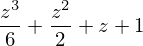

In [28]:
"""
test process on RK3 Shu-Osher
"""
rk33so = rk_scheme(3,label="RK(3,3) Shu-Osher")
rk33so[0] = un + dt*L(un)
rk33so[1] = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*L(u1)
rk33so[2] = sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*L(u2)

rk33so.stability_function()

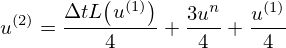

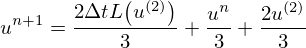

In [29]:
[ display(stage) for stage in rk33so.scheme()];

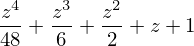

In [30]:
""" RK3 à 4 étages """
rk43 = rk_scheme(4,label="RK(4,3)")
rk43[0] = un + sp.Rational(1,2)*dt*L(un)
rk43[1] = u1 + sp.Rational(1,2)*dt*L(u1)
rk43[2] = sp.Rational(2,3)*un + sp.Rational(1,3)*u2 + sp.Rational(1,6)*dt*L(u2)
rk43[3] = u3 + sp.Rational(1,2)*dt*L(u3)

rk43.stability_function()

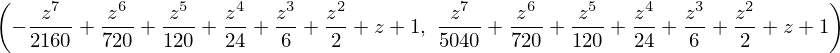

In [31]:
""" RK6 à 7 étages [Luther H. A. (1968)] """
nu = sp.symbols("\\nu")
s21 = sp.sqrt(21)

rk76 = rk_scheme(8,label="RK(7,6)")
rk76.ui = name_stages("k",8)
rk76.ui[0] = rk_scheme.ui[0]
rk76.ui[-1] = rk_scheme.ui[-1]
k1,k2,k3,k4,k5,k6,k7 = rk76.ui[1:-1]

rk76[0] = dt*L(un)
rk76[1] = dt*L(un+nu*k1)
rk76[2] = dt*L(un+ ((4*nu-1)*k1+k2)/(8*nu) )
rk76[3] = dt*L(un+ ((10*nu-2)*k1 + 2*k2 + 8*nu*k3)/(27*nu) )
rk76[4] = dt*L(un+ (-((77*nu-56)+(17*nu-8)*s21)*k1
                -8*(7+s21)*k2 + 48*(7+s21)*nu*k3
                -3*(21+s21)*nu*k4)/(392*nu) )
rk76[5] = dt*L(un+ (-5*((287*nu-56)-(59*nu-8)*s21)*k1
                - 40*(7-s21)*k2 + 320*s21*nu*k3 + 3*(21-121*s21)*nu*k4
                + 392*(6-s21)*nu*k5)/(1960*nu) )
rk76[6] = dt*L(un+ ( 15*((30*nu-8)-(7*nu*s21))*k1 + 120*k2
                - 40*(5+7*s21)*nu*k3 + 63*(2+3*s21)*nu*k4
                - 14*(49-9*s21)*nu*k5 + 70*(7+s21)*nu*k6)/(180*nu) )
rk76[7] = un + (9*k1 + 64*k3 + 49*k5 + 49*k6 + 9*k7)/180

display((rk76.stability_function(),poly_carac(7)))
del s21,nu,k1,k2,k3,k4,k5,k6,k7

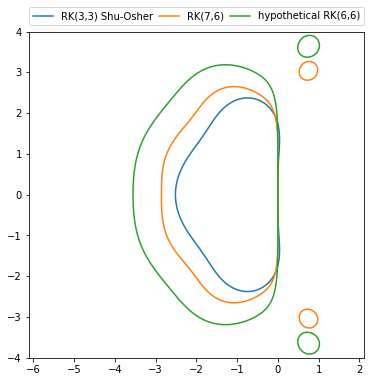

In [32]:
plt.rcParams['figure.figsize'] = [6,6]

rk33so.stability_domain(colors=default.palette[0],Ir=(-6.,2.,500),Ii=(-4.,4.,500))
rk76.stability_domain(colors=default.palette[1],Ir=(-6.,2.,500),Ii=(-4.,4.,500))
contour(sp.Abs(poly_carac(6)),z,(-6.,2.,500),(-4.,4.,500), levels=[1.],colors=default.palette[2],label="hypothetical RK(6,6)")

plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

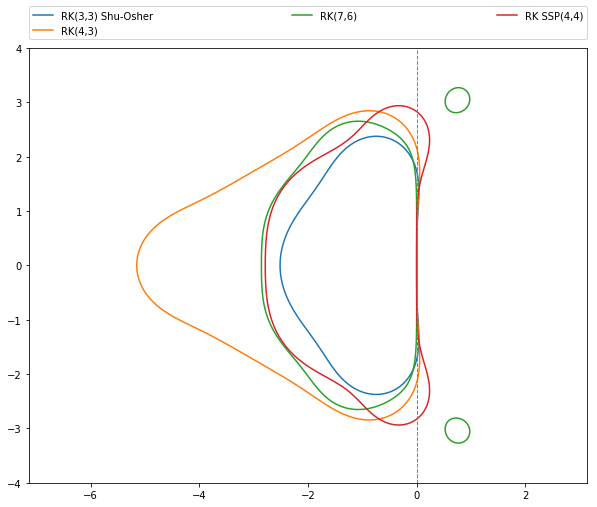

In [33]:
plt.rcParams['figure.figsize'] = [10,8]

for i,rk in enumerate((rk33so,rk43,rk76)) :
  rk.stability_domain((-6.,2.,500),(-4.,4.,500),colors=default.palette[i])
contour(sp.Abs(poly_carac(4)),z,(-6.,2.,500),(-4.,4.,500), levels=[1.],colors=default.palette[i+1],label="RK SSP(4,4)")

plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)

plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del i,rk

### 2.1.2 Obtention de la fonction de stabilité depuis un tableau de Butcher

Il est souvent plus simple de ne donner qu'un tableau de Butcher d'une méthode, et cela permet en réalité d'extraire plus d'informations. Dans un premier temps, l'implémentation, se limitera aux méthodes eRK (*explicit Runge-Kutta method*), par la suite cette implémentation sera généralisé au cadre des méthodes DIRK (*Diagonal Implicit Runge-Kutta method*), le cadre général étant plus embêtant pour l'obtention algorithmique de la fonction de stabilité.

La fonction `poly_butcher` fonctionne pour un tableau de Butcher écrit comme suit :

$$
  \begin{array}{c|c}
    \begin{matrix}
      a_{11} & \cdots & a_{1s} \\
      \vdots & \ddots & \vdots \\
      a_{s1} & \cdots & a_{ss}
    \end{matrix} & \begin{matrix} b_1 \\ \vdots \\ b_s \end{matrix} \\ \hline
    \begin{matrix}c_1 & \cdots & c_s \end{matrix} & \\
  \end{array}
$$

Le schéma qui en résulte est de la forme :

$$
  \begin{aligned}
    u^{(i)} &= u^n + \Delta t \sum_j a_{ij} L(t^n+b_j\Delta t , u^{(j)}) \\
    u^{n+1} &= u^n + \Delta t \sum_i c_i L(t^n+b_i\Delta t , u^{(i)})
  \end{aligned}
$$

Ce schéma est explicite si et seulement si la matrice $A$ est triangulaire strictement inférieure (pour un schéma DIRK la matrice $A$ est triangulaire inférieure, le caractère implicite est donnée par la diagonale). On ne précisera pas ici les propriétés liant $A$, $b$ et $c$ pour déterminer l'ordre de la méthode, son caractère SSP ou autre.

Dans l'obtention du polynôme caractéristique du schéma, le vecteur $b$ n'est pas nécessaire puisqu'on linéarise l'opération $L(t^n+b_j\Delta t , u^{(j)})$ par $\lambda u^{(j)}$.

In [34]:
def poly_butcher( A , c , b=None ):
  """
    /!\ fonction ne fonctionnant que pour des schémas explicites
    pour des méthodes DIRK, revoir cette fonction en créeant un tableau
    de symbols u_s et en cherchant comment expliciter la diagonale implicite
  """
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_s[i] = 1 + dt*sum([ A[i][j]*lamb*u_s[j] for j in r ])
  un1 = 1 + dt*sum([ c[j]*lamb*u_s[j] for j in r ])
  return un1.expand().collect(z).subs(dt*lamb,z).collect(z)

class rk_butcher(object):
  def __init__ (self,A,c,b=None,label=None):
    self.A = A
    self.b = b
    self.c = c
    self.label = label
    self._data = None
    if b == None:
      self.b = [ sum(A[i][:]) for i in range(len(c)) ]
  
  def stages(self):
    return len(self.c)
  
  def stability_function(self):
    return poly_butcher(A=self.A,b=self.b,c=self.c)
  
  def order(self):
    rest = sum([ sp.Rational(1,(math.factorial(n)))*z**n for n in range(len(self.A)+2) ]) - self.poly()
    return next(i for i,j in enumerate(reversed(sp.Poly(rest).as_list())) if j)-1
  
  def stability_domain (self,Ir=(-4.,2.,100),Ii=(-3.,3.,100),**kwargs) :
    return contour(sp.Abs(self.stability_function()),z,Ir,Ii,levels=[1.],label=self.label,**kwargs)

In [35]:
A = [[0]]
b = [0]
c = [1]

rk1 = rk_butcher(A=A,b=b,c=c,label="Euler")
del A,b,c
rk1.stability_function()

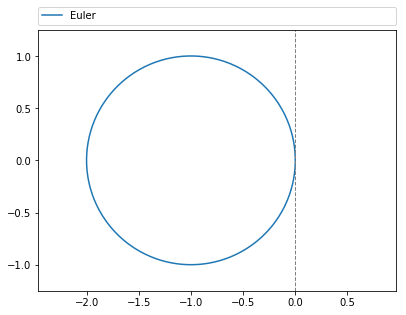

In [36]:
rk1.stability_domain(Ir=(-2,0.5),Ii=(-1.25,1.25),colors=default.palette[0])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

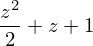

In [37]:
A = [[0,0],
     [1,0]]
b = [0,1]
c = [sp.Rational(1,2),sp.Rational(1,2)]

rk2 = rk_butcher(A=A,b=b,c=c,label="RK SSP (2,2)")
del A,b,c
rk2.stability_function()

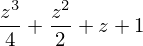

In [38]:
A = [[0,0,0],
     [sp.Rational(1,2),0,0],
     [0,sp.Rational(1,2),0]]
b = [0,sp.Rational(1,2),sp.Rational(1,2)]
c = [0,0,1]

rk32best = rk_butcher(A=A,b=b,c=c,label="RK (3,2) best")
del A,b,c
rk32best.stability_function()

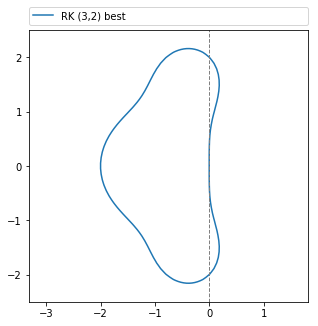

In [39]:
plt.rcParams['figure.figsize'] = [5,5]
rk32best.stability_domain(Ir=(-2,0.5),Ii=(-2.5,2.5),colors=default.palette[0])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

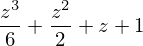

In [40]:
""" vérification sur RK3 """
A = [[0,0,0],
     [1,0,0],
     [sp.Rational(1,4),sp.Rational(1,4),0]]
b = [0,1,sp.Rational(1,2)]
c = [sp.Rational(1,6),sp.Rational(1,6),sp.Rational(2,3)]

rk33 = rk_butcher(A=A,b=b,c=c,label="RK (3,3)")
del A,b,c
rk33.stability_function()

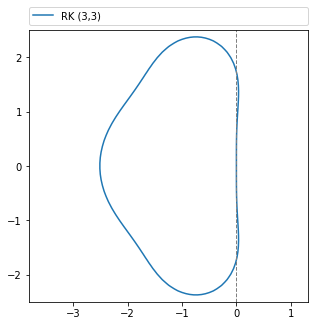

In [41]:
plt.rcParams['figure.figsize'] = [5,5]
rk33.stability_domain(Ir=(-3,0.5),Ii=(-2.5,2.5),colors=default.palette[0])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

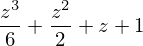

In [42]:
A = [[0,0,0],
     [sp.Rational(1,2),0,0],
     [-1,2,0]]
c = [sp.Rational(1,6),sp.Rational(4,6),sp.Rational(1,6)]
b = [0,sp.Rational(1,2),1]

rk33bis = rk_butcher(A=A,b=b,c=c,label="RK (3,3) bis")
del A,b,c
rk33bis.stability_function()

Les 2 méthodes Runge-Kutta d'ordre 3 à 3 étages ont la même fonction de stabilité, par conséquent les CFL obtenues seront les mêmes et toutes les autres propriétés issues de cette fonction aussi (order-star). En revanche le schéma reste différent et l'erreur aussi (mais la convergence de l'erreur est bien la même, seule la constante diffère).

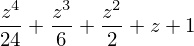

In [43]:
""" vérification sur RK4 """
A = [[ 0               , 0               , 0 , 0 ] ,
     [ sp.Rational(1,2), 0               , 0 , 0 ] ,
     [ 0               , sp.Rational(1,2), 0 , 0 ] ,
     [ 0               , 0               , 1 , 0 ]]
b = [0,sp.Rational(1,2),sp.Rational(1,2),1]
c = [sp.Rational(1,6),sp.Rational(1,3),sp.Rational(1,3),sp.Rational(1,6)]

rk44 = rk_butcher(A=A,b=b,c=c,label="RK (4,4)")
del A,b,c
rk44.stability_function()

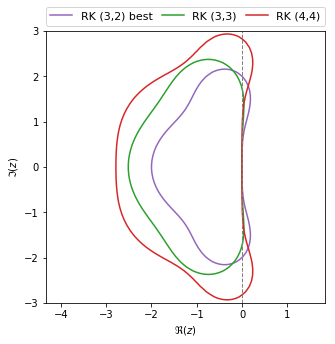

In [44]:
plt.rcParams['figure.figsize'] = [5,5]
rk32best.stability_domain(Ir=(-2,0.5),Ii=(-2.5,2.5),colors=default.palette[4])
rk33.stability_domain(Ir=(-3,0.5),Ii=(-2.5,2.5),colors=default.palette[2])
rk44.stability_domain(Ir=(-3,0.5),Ii=(-3.,3.),colors=default.palette[3])
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,prop={'size': 11})
plt.xlabel(r"$\Re(z)$")
plt.ylabel(r"$\Im(z)$")

plt.show()
plt.rcParams['figure.figsize'] = default.figsize

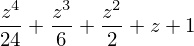

In [45]:
""" test sur RK4 3/8-rule """
A = [[ 0               , 0 , 0 , 0 ],
     [ sp.Rational(1,3), 0 , 0 , 0 ],
     [-sp.Rational(1,3), 1 , 0 , 0 ],
     [ 1               ,-1 , 1 , 0 ]]
b = [0,sp.Rational(1,3),sp.Rational(2,3),1]
c = [sp.Rational(1,8),sp.Rational(3,8),sp.Rational(3,8),sp.Rational(1,8)]

rk44_38 = rk_butcher(A=A,b=b,c=c,label="RK (4,4) 3/8 rule")
del A,b,c
rk44_38.stability_function()

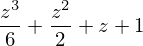

In [46]:
""" test sur RK NSSP(3,3) [Wang R. and Spiteri R. J. (2007)] """
A = [[0,0,0],
     [-sp.Rational(4,9),0,0],
     [sp.Rational(7,6),-sp.Rational(1,2),0]]
b = [0,-sp.Rational(4,9),sp.Rational(2,3)]
c = [sp.Rational(1,4),0,sp.Rational(3,4)]

rknssp33 = rk_butcher(A=A,b=b,c=c,label="RK NSSP (3,3)")
del A,b,c
rknssp33.stability_function()

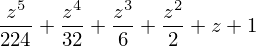

In [47]:
""" test sur RK NSSP(5,3) [Wang R. and Spiteri R. J. (2007)] """
A = [[ 0 , 0 , 0 , 0 , 0 ]                 ,
     [ sp.Rational(1,7)  , 0 , 0 , 0 , 0 ] ,
     [ 0 , sp.Rational(3,16) , 0 , 0 , 0 ] ,
     [ 0 , 0 , sp.Rational(1,3)  , 0 , 0 ] ,
     [ 0 , 0 , 0 , sp.Rational(2,3)  , 0 ]]
b = [0,sp.Rational(1,7),sp.Rational(3,16),sp.Rational(1,3),sp.Rational(2,3)]
c = [sp.Rational(1,4),0,0,0,sp.Rational(3,4)]

rk53 = rk_butcher(A=A,b=b,c=c,label="RK NSSP (5,3)")
del A,b,c
rk53.stability_function()

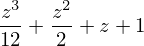

In [48]:
""" test sur RK SSP(3,2) [Wang R. and Spiteri R. J. (2007)] """
A = [[ 0                , 0                , 0 ],
     [ sp.Rational(1,2) , 0                , 0 ],
     [ sp.Rational(1,2) , sp.Rational(1,2) , 0 ]]
b =  [ 0 , sp.Rational(1,2) , 1 ]
c =  [ sp.Rational(1,3) , sp.Rational(1,3) , sp.Rational(1,3) ]

rk32 = rk_butcher(A=A,b=b,c=c,label="RK SSP (3,2)")
del A,b,c
rk32.stability_function()

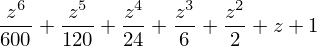

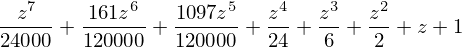

In [49]:
""" test sur DP 5 (Dormand-Prince) [Motamed M. and Macdonald C. and Ruuth S. (2010)] """
A = [[ 0                       , 0                       , 0                       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(1,5)        , 0                       , 0                       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(3,40)       , sp.Rational(9,40)       , 0                       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(44,45)      ,-sp.Rational(56,15)      , sp.Rational(32,9)       , 0                    , 0                       , 0                  , 0 ],
     [ sp.Rational(19372,6561) ,-sp.Rational(25360,2187) , sp.Rational(64448,6561) ,-sp.Rational(212,729) , 0                       , 0                  , 0 ],
     [ sp.Rational(9017,3168)  ,-sp.Rational(355,33)     , sp.Rational(46732,5247) , sp.Rational(49,176)  ,-sp.Rational(5103,18656) , 0                  , 0 ],
     [ sp.Rational(35,384)     , 0                       , sp.Rational(500,1113)   , sp.Rational(125,192) ,-sp.Rational(2187,6784)  , sp.Rational(11,84) , 0 ]]
c1 = [ sp.Rational(35,384)     , 0                       , sp.Rational(500,1113)   , sp.Rational(125,192) ,-sp.Rational(2187,6784)  , sp.Rational(11,84) , 0 ]
c2 = [ sp.Rational(5179,57600) , 0                       , sp.Rational(7571,16695) , sp.Rational(393,640) ,-sp.Rational(92097,339200) , sp.Rational(187,2100) , sp.Rational(1,40) ]
b = [0,sp.Rational(1,5),sp.Rational(3,10),sp.Rational(4,5),sp.Rational(8,9),1,1]

dp5 = rk_butcher(A=A,b=b,c=c1,label="DP5 RK(6,5)")
dp5_4 = rk_butcher(A=A,b=b,c=c2,label="DP5(4) RK(7,4)")
del A,b,c1,c2
display(dp5.stability_function())
display(dp5_4.stability_function())

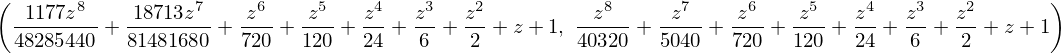

In [50]:
""" test sur RK (8,6) [Banks J. W. et all (2019)] """
A = [[  0 ,  0 , 0 , 0 , 0 , 0 , 0 , 0 ] ,
     [  sp.Rational(1,9)             ,  0                         ,  0                          ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(1,24)            ,  sp.Rational(1,8)          ,  0                          ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(1,6)             , -sp.Rational(1,2)          ,  sp.Rational(2,3)           ,  0                           ,  0                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(935,2536)        , -sp.Rational(2781,2536)    ,  sp.Rational(309,317)       ,  sp.Rational(321,1268)       ,  0                      , 0                     , 0                  , 0 ] ,
     [ -sp.Rational(12710,951)       ,  sp.Rational(8287,317)     , -sp.Rational(40,317)        , -sp.Rational(6335,317)       ,  8                      , 0                     , 0                  , 0 ] ,
     [  sp.Rational(5840285,3104064) , -sp.Rational(7019,2536)    , -sp.Rational(52213,86224)   ,  sp.Rational(1278709,517344) , -sp.Rational(433,2448)  , sp.Rational(33,1088)  , 0                  , 0 ] , 
     [ -sp.Rational(5101675,1767592) ,  sp.Rational(112077,25994) ,  sp.Rational(334875,441898) , -sp.Rational(973617,883796)  , -sp.Rational(1421,1394) , sp.Rational(333,5576) , sp.Rational(36,41) , 0 ]]

c =  [  sp.Rational(41,840)          ,  0                         ,  sp.Rational(9,35)          ,  sp.Rational(9,280)          ,  sp.Rational(34,105)    , sp.Rational(9,280)    , sp.Rational(9,35)  , sp.Rational(41,840) ]
b =  [ 0 , sp.Rational(1,9) , sp.Rational(1,6) , sp.Rational(1,3) , sp.Rational(1,2) , sp.Rational(2,3) , sp.Rational(5,6) , 1 ]

rk86 = rk_butcher(A=A,b=b,c=c,label="RK (8,6)")
del A,b,c
(rk86.stability_function(),poly_carac(8))

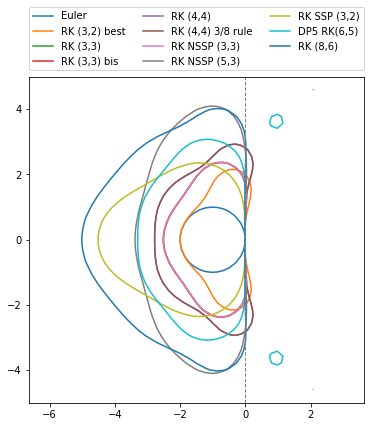

In [51]:
plt.rcParams['figure.figsize'] = [6,6]

for i,rk in enumerate((rk1,rk32best,rk33,rk33bis,rk44,rk44_38,rknssp33,rk53,rk32,dp5,rk86)):
  rk.stability_domain(Ir=(-6,3),Ii=(-5,5), colors=default.palette[i%len(default.palette)])

plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del i,rk

On peut souhaiter effectuer l'opération inverse, à partir d'une fonction de stabilité polynômiale (maximisant par exemple la stabilité sur l'axe imaginaire) retrouver le tableau de Butcher (et donc le schéma). Pour cela on calcule la fonction de stabilité d'une matrice $A=(a_{ij})_{ij}$ et un vecteur $c = (c_j)_j$, et on cherche à obtenir les relations d'ordre.

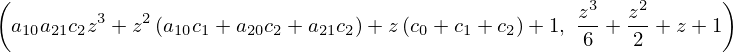

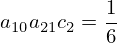

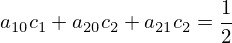

In [52]:
s=3
rk_coef = rk_butcher(A=np.array(sp.symbols('a_:%i:%i'%(s,s))).reshape((s,s)),
                  b=sp.symbols('b:%i'%s),
                  c=sp.symbols('c:%i'%s))

pb = sp.Poly(rk_coef.stability_function(),z)
pc = sp.Poly(poly_carac(s),z)

# égalités entre le polynôme caractéristique et les coefficients de Butcher
display((pb.as_expr(),pc.as_expr()))
[display(sp.Eq(cb,cc)) for (cb,cc) in zip( pb.coeffs() , pc.coeffs() )];
del s,rk_coef,pb,pc

Maintenant il faut savoir quoi faire de ces relations d'ordre. On peut par exemple contraindre la forme de la matrice $A$ (par exemple diagonale inférieure, comme dans RK NSSP(5,3)), la positivité de certains coefficients, d'autres relations pour assurer un caractère SSP ou non, etc.

> Il est normal que le résultat donné ici ne donne qu'une relation faisant intervenir $a_{10}$, $a_{20}$ et $a_{21}$ puisque pour le moment la fonction `poly_butcher` ne fonctionne qu'avec une méthode RK explicite. L'étude de DIRK2 par exemple nécessiterait une amélioration de la fonction.

On peut vouloir aussi écrire le schéma issu d'un tableau de Butcher. Par défaut le schéma obtenu directement à l'aide d'un tableau de Butcher n'est pas optimal d'un point de vue numérique dans le sens où il sous entend plus que $s$ (le nombre d'étages de la méthode) évaluations de la fonction $L$. Une amélioration du schéma est possible à l'aide d'un jeu de substituion des étapes précédentes.

In [53]:
tn = sp.symbols("t^n",real=True)

def butcher_scheme ( A , b , c , shu_osher=False ):
  us = name_stages("u",len(c))
  scheme_stages = []
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_si = us[0] + dt*sum([ A[i][j]*L(tn+b[j]*dt,us[j]) for j in r ])
    scheme_stages.append(sp.Eq(us[i],u_si))
  un1 = us[0] + dt*sum([ c[i]*L(tn+b[i]*dt,us[i]) for i in r ])
  scheme_stages.append(sp.Eq(us[-1],un1))
  
  scheme_stages = scheme_stages[1:]
  if shu_osher :
    L_subs = []
    for i,eq in enumerate(scheme_stages[:-1]):
      scheme_stages[i] = eq.subs(L_subs).simplify().expand()
      L_subs.append(( L(tn+b[i]*dt,us[i]) , sp.solve(scheme_stages[i],L(tn+b[i]*dt,us[i]))[0] ))
    scheme_stages[-1] = scheme_stages[-1].subs(L_subs).expand()
                    
  return scheme_stages

rk_butcher.scheme = lambda self,shu_osher=False:butcher_scheme(self.A,self.b,self.c,shu_osher)

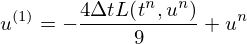

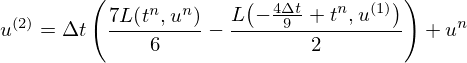

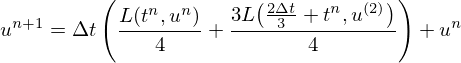

In [54]:
rk = rknssp33
[ display(eq) for eq in rk.scheme(shu_osher=False) ];
del rk

### 2.1.3 Récapitulatif des domaines des différentes méthodes en temps

On peut résumer tous les schémas en temps présentés par la figure ci-dessous.

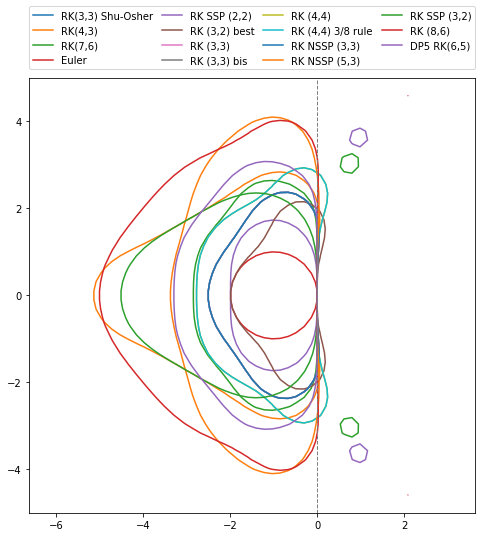

In [55]:
plt.rcParams['figure.figsize'] = [8,8]

for i,rk in enumerate((rk33so,rk43,rk76,rk1,rk2,rk32best,rk33,rk33bis,rk44,rk44_38,rknssp33,rk53,rk32,rk86,dp5)):
  rk.stability_domain(Ir=(-6,3),Ii=(-5,5),colors=default.palette[i%len(default.palette)])
  
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del i,rk

### 2.1.4 Recherche du meilleur domaine de stabilité

Nicolas est intéressé par effectuer une étude un peu inverse, c'est-à-dire trouver le meilleur coefficient $\alpha$ tel que le polynôme caractéristique :

$$
  \alpha z^4 + \frac{z^3}{6} + \frac{z^2}{2} + z + 1
$$

ait le plus grand domaine de stabilité (en particulier sur l'axe imaginaire, pour exprimer la stabilité d'un schéma non diffusif). C'est à dire ajouter un étage sur une méthode RK3 existante, telle que celle-ci obtienne une meilleure stabilité.

In [56]:
alpha = sp.symbols("\\alpha",real=True,positive=True)

def poly_RKn1n(n):
  """ return stability function of explicit RK(n+1,n) scheme with alpha coefficient for the last coeff """
  return alpha*z**(n+1) + poly_carac(n)

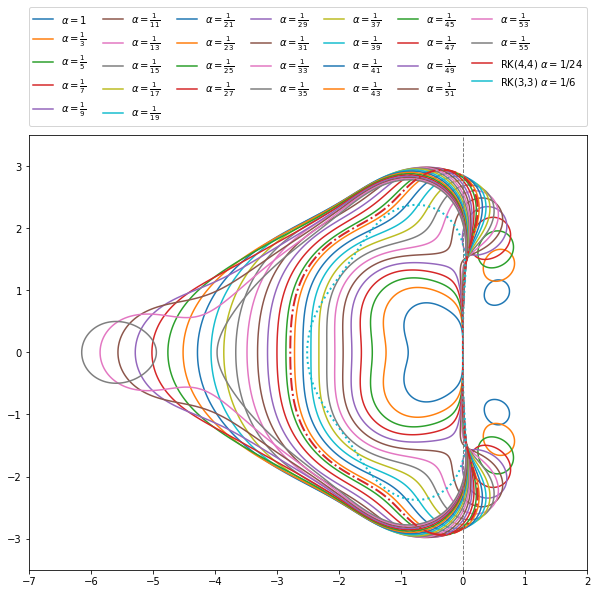

In [57]:
n = 3

plt.rcParams['figure.figsize'] = [10,8]
for k in range(1,57,2):
  print(k,end="\r")
  contour(sp.Abs(poly_RKn1n(n)).subs(alpha,sp.Rational(1,k)),z,(-7.,2.,500),(-3.5,3.5,500), levels=[1.],colors=default.palette[int((k-1)/2)%len(default.palette)],label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,k))))
print(" "*len(str(k)))
contour(sp.Abs(poly_carac(n+1)),z,(-7.,2.,500),(-3.5,3.5,500),linewidths=2,linestyles=['-.'],levels=[1.],colors=default.palette[3],label="RK({},{}) $\\alpha = {}$".format(n+1,n+1,sp.Rational(1,sp.factorial(n+1))))
contour(sp.Abs(poly_carac(n)),z,(-7.,2.,500),(-3.5,3.5,500),linewidths=2,linestyles=[':'],levels=[1.],colors=default.palette[9],label="RK({},{}) $\\alpha = {}$".format(n,n,sp.Rational(1,sp.factorial(n))))

plt.legend(loc=(0.,1.02),ncol=7,mode="expand",borderaxespad=0.)
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del n,k

Ce qui nous intéresse ici est de maximiser le domaine de stabilité sur l'axe imaginaire. Il est très compliqué de chercher à maximiser le domaine de stabilité d'une méthode RK($s$,$n$) pour WENO. En plus de cela il est nécessaire de trouver par la suite une solution aux relations d'ordre dans la fonction de stabilité.

La maximisation du domaine sur l'axe imaginaire permet de stabiliser avec la plus grande CFL possible un transport pur. Le coefficient $\alpha$ maximisant le domaine sur l'axe imaginaire avec un RK2 à 3 étages est $\alpha = \frac{1}{4}$.

> **Preuve :** considérons le polynôme caractéristique $R_{\alpha}$ d'un schéma RK2 à 3 étages avec un coefficient $\alpha$ :
> 
> $$
  R_{\alpha}(z) = 1 + z + \frac{z^2}{2} + \alpha z^3
$$
> 
> On cherche à évaluer le polynôme en $z=i\beta$, correspondant à l'intersection de l'ensemble $\{ z\ /\  |R_\alpha(z)|=1 \}$ avec l'axe imaginaire.
> 
> $$
  R_\alpha(i\beta) = 1 + i\beta - \frac{\beta^2}{2} - i\beta^3\alpha
$$
> 
> on souhaite un module égale à 1 :
> 
> $$
  1 = |R_\alpha(i\beta)|^2 = \left(1-\frac{\beta^2}{2}\right)^2 + \left(\beta - \beta^3\alpha \right)^2
$$
> 
> ce qui peut se simplifier par :
> 
> $$
  \alpha^2\beta^6 + (\frac{1}{4}-2\alpha)\beta^4 = 0
$$
>
>En supposant $\beta \neq 0$ :
>
>$$
  \alpha^2\beta^2 -2\alpha + \frac{1}{4} = 0
$$
>
>soit :
>
>$$
  \beta^2 = \frac{2\alpha - \frac{1}{4}}{\alpha^2}
$$
>
>on obtient ainsi une fonction $\beta^2:\alpha\mapsto \frac{2\alpha - \frac{1}{4}}{\alpha^2}$ dont on souhaite trouver le maximum (ou plus exactement le coefficient $\alpha$ où est atteint le maximum, ce qui explique que l'on ne s'intéresse qu'au coefficient $\beta^2$ et non explicitement $\beta$).
>
>$$
  \left(\beta^2\right)'(\alpha) = \frac{-2\alpha^2 + \frac{\alpha}{2}}{\alpha^4}
$$
>
>la dérivée s'annule en $\alpha = \frac{1}{4}$ □


La maximisation du domaine sur l'axe imaginaire ne permet pas rigoureusement de maximiser la CFL du couple de schéma RK$^\alpha N$-WENO mais permet de se donner une idée ; prenons par exemple le cas de RK2 à 3 étages, comme dit précédemment le coefficient $\alpha$ maximisant le domaine de stabilité sur l'axe imaginaire est $\alpha = \frac{1}{4}$, représenté par le courbe orange sur la figure, or il est possible d'obtenir une CFL plus importante avec le coefficient $\alpha=\frac{1}{5}$, pour lequel on représente le coefficient d'amplification en rose de WENO$\times$1.4 (sans aller chercher $\alpha=\frac{1}{6}$ qui correspond à RK3).

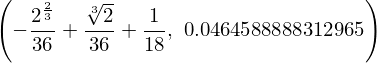

In [58]:
"""
  automatic compute for the best alpha coeficient to maximize stability domain on imaginary axis
"""
n=3 # avec n=2 on retrouve bien 1/4
beta = sp.symbols("\\beta",real=True,positive=True)
p = poly_RKn1n(n)

alphas = []
# on cherche à résoudre $|p(ib)|^2 -1 = 0$, solutions auxquels on soustrait 0
# puis on dérive les solutions (qui dépendent de alpha) pour savoir où la dérivée s'annule et donc où beta
# est maximisé
for a in sp.solveset((sp.Abs(p.subs(z,beta*I))**2-1).collect(beta),beta**2)-sp.sets.FiniteSet(0):
  betaset = sp.solveset(a.diff(alpha),alpha,domain=sp.S.Reals)
  if betaset != sp.EmptySet() :
    alphas.extend(betaset)
display((alphas[0],alphas[0].evalf()))

del beta,p,a,betaset

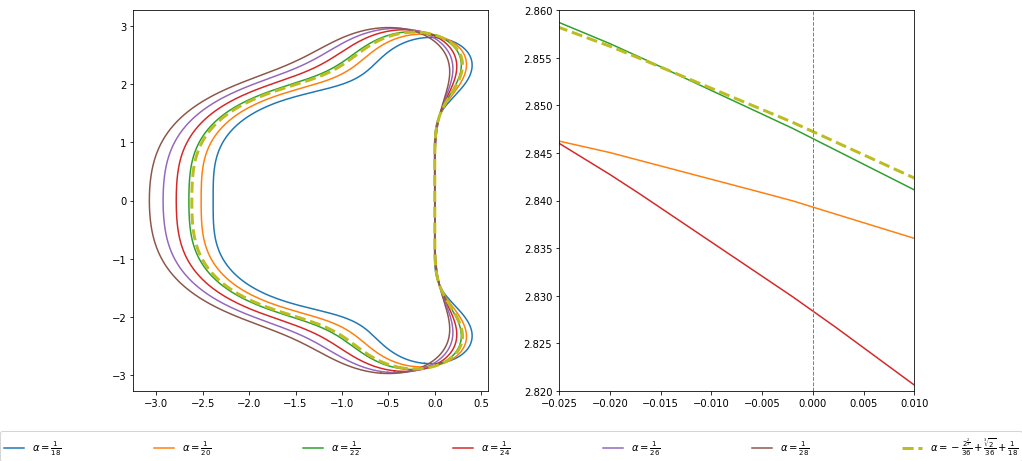

In [59]:
""" visualisation of this result """

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,7))
p = poly_RKn1n(n)

for i,k in enumerate(range(int(1./alphas[0].evalf())-3,int(1./alphas[0].evalf())+9,2)):
  print(k,end="\r")
  tmp_fig = plt.figure()
  tmp = contour(sp.Abs(poly_RKn1n(n)).subs(alpha,sp.Rational(1,k)),z,(-7.,2.,500),(-3.5,3.5,500), levels=[1.]).allsegs[0]
  data = max(tmp,key=lambda dat:len(dat))
  plt.close(tmp_fig); del tmp_fig,tmp
  ax1.plot(data[:,0],data[:,1],color=default.palette[i%len(default.palette)],label="$\\alpha = {}$".format(sp.latex(sp.Rational(1,k))))
  ax2.plot(data[:,0],data[:,1],color=default.palette[i%len(default.palette)])
  
print(alphas[0],end="\r")
tmp_fig = plt.figure()
tmp = contour(sp.Abs(poly_RKn1n(n)).subs(alpha,alphas[0]),z,(-7.,2.,500),(-3.5,3.5,500), levels=[1.],colors=default.palette[int((k-1)/2)%len(default.palette)],label="$\\alpha = {}$".format(alphas[0])).allsegs[0]
data = max(tmp,key=lambda dat:len(dat))
plt.close(tmp_fig); del tmp_fig,tmp
ax1.plot(data[:,0],data[:,1],'--',color=default.palette[(i+3)%len(default.palette)],linewidth=3,label="$\\alpha = {}$".format(sp.latex(alphas[0])))
ax2.plot(data[:,0],data[:,1],'--',color=default.palette[(i+3)%len(default.palette)],linewidth=3)
ax2.axvline(0, color='gray',linestyle='--',linewidth=1.)
print(" "*len(str(alphas[0])))

fig.legend(loc=(0.,0.),ncol=7,mode="expand",borderaxespad=0.,markerscale=10)
ax2.set_xlim([-0.025,0.01]) ; ax2.set_ylim([2.82,2.86])
plt.show()

del fig,ax1,ax2,p,i,k,data

### 2.1.5 Order star

Il est possible assez facilement, pour étudier certaines propriétés de nos schémas en temps, de tracer l'*order star* (n'ayant vu aucun article francophone en parler j'utlise le terme en anglais). L'*order star* est définie comme : $\{\mathcal{A}_+,\mathcal{A}_0,\mathcal{A}_-\}$ avec :

* $\mathcal{A}_+ = \left\{ z\in\mathbb{C}\,:\, |e^{-z}R(z)|>1 \right\}$
* $\mathcal{A}_0 = \left\{ z\in\mathbb{C}\,:\, |e^{-z}R(z)|=1 \right\}$
* $\mathcal{A}_- = \left\{ z\in\mathbb{C}\,:\, |e^{-z}R(z)|<1 \right\}$

où $R$ est le polynôme caractéristique, ou approximation de Padé de la fonction à étudier.

> Pour des raisons techniques, il est plus simple de colorier l'ensemble des points du plan dont la valeur d'une fonction est comprise entre 2 bornes finies, par conséquent, en bleu, nous alons afficher $ \mathcal{A}_-$.

In [60]:
def contourf ( expr , z , Ir , Ii , **kwargs):
  x,y = sp.symbols("x y",real=True)
  f = sp.lambdify((x, y), expr.subs(z,x+I*y),'numpy')
  
  a = np.linspace(*Ir)
  b = np.linspace(*Ii)
  X, Y = np.meshgrid(a, b)
  try:
    lab = kwargs.pop("label")
  except:
    lab = ""
  try:
    c = kwargs["colors"]
  except:
    c = palette[0]
  if len(lab) > 0 :
    plt.plot([0],[0],'s',markersize=1,label=lab,color=c)
  return plt.contourf(X,Y, f(X,Y).real,**kwargs)

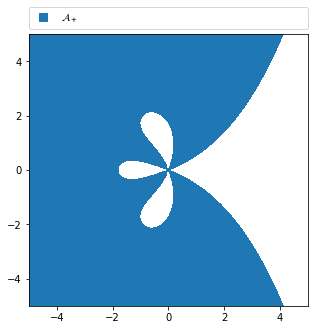

In [61]:
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(sp.exp(-z)*rk33.stability_function()),z,(-5,5,100),(-5,5,100),levels=[1.,1.e299],colors=default.palette[0],label="$\mathcal{A}_+$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

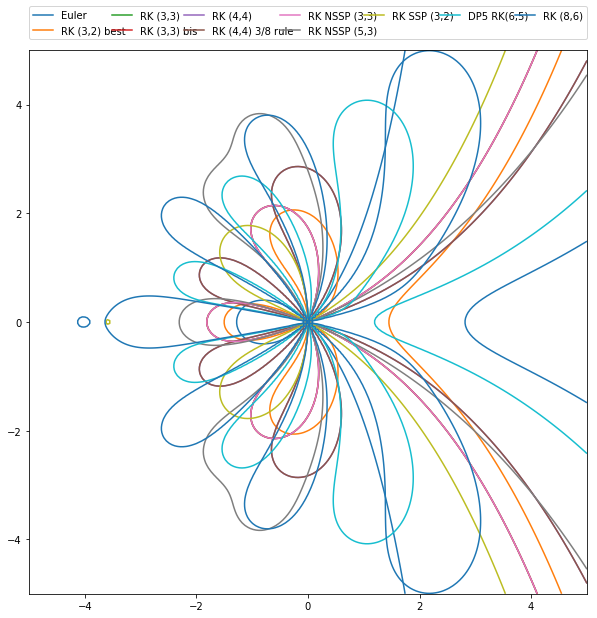

In [62]:
plt.rcParams['figure.figsize'] = [10,10]

for i,rk in enumerate((rk1,rk32best,rk33,rk33bis,rk44,rk44_38,rknssp33,rk53,rk32,dp5,rk86)):
  contour(sp.Abs(sp.exp(-z)*rk.stability_function()),z,(-5,5,200),(-5,5,200),levels=[1.],colors=default.palette[i%len(default.palette)],label=rk.label )

plt.legend(loc=(0.,1.02),ncol=7,mode="expand",borderaxespad=0.)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

## 2.2 Méthode diagonal implicit Runge-Kutta

Nous n'avons étudier jusqu'à présent que des schémas de type Runge-Kutta explicite (ou eRK), et cela se traduit par un tableau de Butcher triangulaire strictement inférieur. Le cas général d'un tableau de Butcher plein est envisageable, le schéma est alors implicite, ce qui permet souvent d'améliorer sa stabilité au détriment du coût de calcul (à cause de l'inversion d'un système). Le compromis de DIRK est de ne rendre que la diagonale implicite. Nous allons étudier ici ce genre de schéma.

L'inversion du schéma WENO nécessaire dans une méthode implicite étant un problème compliqué (voir [[S. Gottlieb, J. Mullen et S. Ruuth]](http://doi.org/10.1007/s10915-005-9034-z)), on se contentera de la présentation de ces méthodes.

In [63]:
def poly_dirk( A , c , b=0 ):
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_si = un + dt*sum([ A[i][j]*lamb*sp.symbols("u^{}".format(j)) for j in r ])
    for j in range(i) :
      u_si = u_si.subs(sp.symbols("u^{}".format(j)),u_s[j])
    ui = sp.symbols("u^{}".format(i))
    eq = sp.Eq(ui,u_si)
    u_s[i] = sp.solve(eq,ui)[0]
  un1 = un + dt*sum([ c[j]*lamb*u_s[j] for j in r ])
  return un1.subs(sp.symbols("u^0"),u_s[0]).expand().subs(lamb*dt,z).subs(un,1)

def to_gnuplot ( R , z , dic=None ):
  x,y = sp.symbols("x y",real=True)
  r = R.subs(z,x+I*y)
  if dic :
    r = r.subs(dic)
  return str(r)

Commençons par le premier schéma DIRK présenté dans [[Alexander R. (1976)]](https://doi.org/10.1137/0714068), dont voici le tableau de Butcher :

$$
  \begin{array}{c c | c}
    \frac{1}{2}+\frac{1}{2\sqrt{3}} & 0                               & \frac{1}{2} + \frac{1}{2\sqrt{3}} \\
    -\frac{1}{\sqrt{3}}             & \frac{1}{2}+\frac{1}{2\sqrt{3}} & \frac{1}{2} - \frac{1}{2\sqrt{3}} \\
    \hline
    \frac{1}{2}                     & \frac{1}{2} &
  \end{array}
$$

est une méthode DIRK(2,3). Le polynôme caractéristique des méthodes DIRK est une fonction rationnelle.

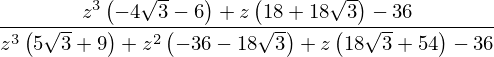

((-4*sqrt(3) - 6)*(x + I*y)**3 + (18 + 18*sqrt(3))*(x + I*y) - 36)/((5*sqrt(3) + 9)*(x + I*y)**3 + (-36 - 18*sqrt(3))*(x + I*y)**2 + (18*sqrt(3) + 54)*(x + I*y) - 36)


In [64]:
A = [[sp.Rational(1,2)+1/(2*sp.sqrt(3)),0                                ],
     [-1/sp.sqrt(3)                    ,sp.Rational(1,2)+1/(2*sp.sqrt(3))]]
c = [ sp.Rational(1,2)                 ,sp.Rational(1,2)                  ]
R = poly_dirk(A=A,c=c).simplify().collect(z)
display(R)
print(to_gnuplot(R,z))
del A,c

On représenter en 3D la fonction rationnelle ainsi obtenue.

![DIRK(2,3)](img/dirk23.png)

Par la suite, on ne présentera que les domaines de stabilité.

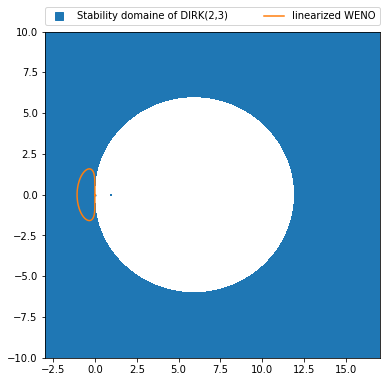

In [65]:
plt.rcParams['figure.figsize'] = [6,6]
contourf(sp.Abs(R),z,(-3,17,500),(-10,10,500),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(2,3)")
plt.plot(*reim(-wenol.ztilde.data),color=default.palette[1],label=wenol.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Il est intéressant de remarquer que :
1. On trace l'opposé du coefficient d'amplification que nous avions précédemment car avec une méthode RK on résout $u_x = -u_x$, or on traçait le coefficient de $+u_x$.
2. Il est important, surtout pour des méthodes implicites, de ne pas tracer que la bordure du domaine de stabilité car (on le verra par la suite) il est difficile de prédire de quel côté de la bordure est le domaine.

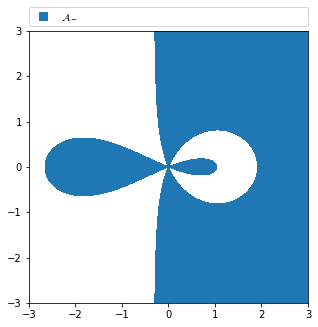

In [66]:
""" order star of DIRK(2,3) """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(sp.exp(-z)*R),z,(-3,3,500),(-3,3,500),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Posons $\alpha = \frac{2\cos\left(\frac{\pi}{18}\right)}{\sqrt{3}}$ :
$$
  \begin{array}{c c c | c}
  \frac{1+\alpha}{2}  & 0                     & 0                   & \frac{1+\alpha}{2} \\
  -\frac{\alpha}{2}   & \frac{1+\alpha}{2}    & 0                   & \frac{1}{2}        \\
  1+\alpha            & -(1+2\alpha)          & \frac{1+\alpha}{2}  & \frac{1-\alpha}{2} \\
  \hline
  \frac{1}{6\alpha^2} & 1-\frac{1}{3\alpha^2} & \frac{1}{6\alpha^2} &
  \end{array}
$$
est une méthode DIRK(3,4).

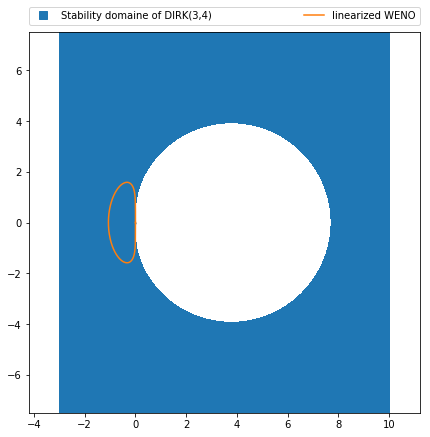

In [67]:
alpha = 2*sp.cos(sp.pi/18)/sp.sqrt(3)
A = [[(1+alpha)/2   ,0               ,0            ],
     [-alpha/2      ,(1+alpha)/2     ,0            ],
     [1+alpha       ,-(1+2*alpha)    ,(1+alpha)/2  ]]
c = [ 1/(6*alpha**2),1-1/(3*alpha**2),1/(6*alpha**2)]
R = poly_dirk(A=A,c=c)

R = R.subs(alpha,alpha.evalf()).collect(z)
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(R),z,(-3,10,100),(-7.5,7.5,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(3,4)")
plt.plot(*reim(-wenol.ztilde.data),color=default.palette[1],label=wenol.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.axis('equal')
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del alpha,A,c

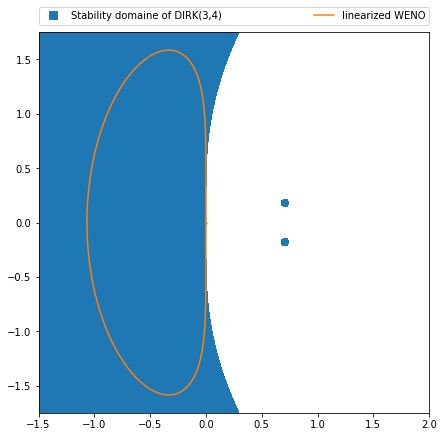

In [68]:
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(R),z,(-1.5,2.,100),(-1.75,1.75,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(3,4)")
plt.plot(*reim(-wenol.ztilde.data),color=default.palette[1],label=wenol.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

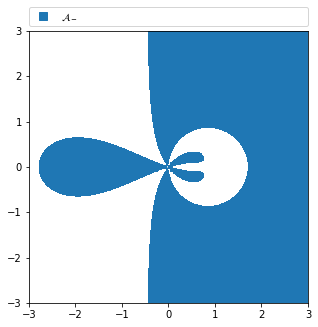

In [69]:
""" order star """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(sp.exp(-z)*R),z,(-3,3,100),(-3,3,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Maintenant deux méthodes *strong S-stable* d'ordre 2 à 2 étages.
$$
  \begin{array}{c c  | c }
    \alpha   & 0      & \alpha \\
    1-\alpha & \alpha & 1 \\
    \hline
    1-\alpha & \alpha &
  \end{array}
$$
avec $\alpha = 1\pm\frac{1}{2}\sqrt{2}$. Les propritétés de stabilités de la méthode changent significativement en fonction de la valeur du coefficient $\alpha$.

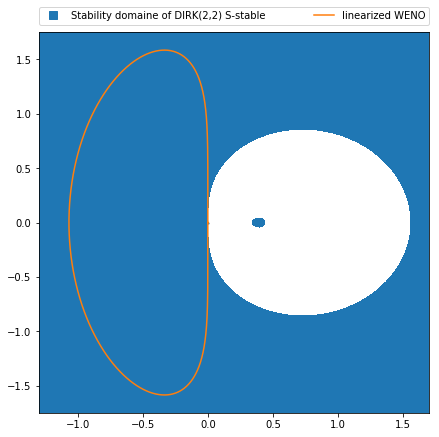

In [70]:
alpha = 1+sp.Rational(1,2)*sp.sqrt(2)
A = [[alpha  ,0    ],
     [1-alpha,alpha]]
c = [ 1-alpha,alpha ]
R = poly_dirk(A=A,c=c).collect(z)

plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(R),z,(-1.3,1.7,100),(-1.75,1.75,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(2,2) S-stable")
plt.plot(*reim(-wenol.ztilde.data),color=default.palette[1],label=wenol.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del alpha,A,c

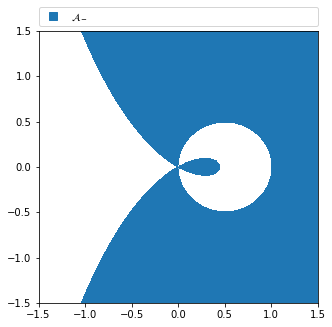

In [71]:
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(R*sp.exp(-z)),z,(-1.5,1.5,100),(-1.5,1.5,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

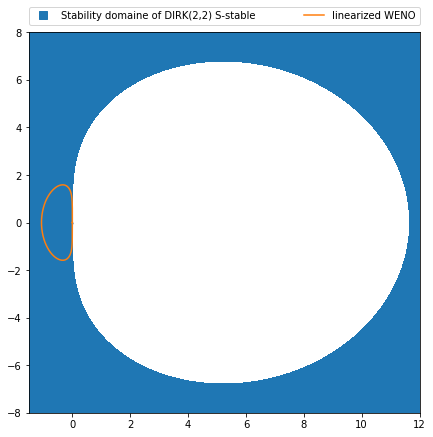

In [72]:
alpha = 1-sp.Rational(1,2)*sp.sqrt(2)
A = [[alpha  ,0    ],
     [1-alpha,alpha]]
c = [ 1-alpha,alpha ]
R = poly_dirk(A=A,c=c).collect(z)

plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(R),z,(-1.5,12.,100),(-8,8,100),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(2,2) S-stable")
plt.plot(*reim(-wenol.ztilde.data),color=default.palette[1],label=wenol.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize
del alpha,A,c

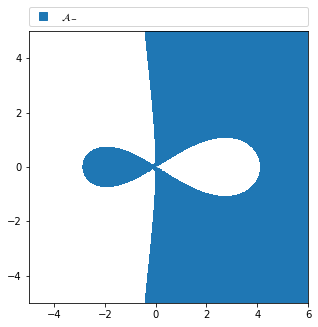

In [73]:
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(R*sp.exp(-z)),z,(-5,6.,100),(-5,5,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Maintenant une méthode *strong S-stable* d'ordre 3 à 3 étages :

$$
  \begin{array}{c c c | c}
    \alpha        & 0      & 0      & \alpha \\
    \tau_2-\alpha & \alpha & 0      & \tau_2 \\
    b_1           & b_2    & \alpha & 1      \\
    \hline
    b_1           & b_2    & \alpha &
  \end{array}
$$

avec $\alpha$ la racine de $x^3-3x+\frac{3}{2}x-\frac{1}{6}=0$ vivant dans $[\frac{1}{6},\frac{1}{2}]$, $\alpha \approx 0.43586652$

* $\tau = \frac{1+\alpha}{2}$
* $b_1 = -\frac{6\alpha^2-16\alpha+1}{4}$
* $b_2 = \frac{6\alpha^2-20\alpha+5}{4}$

In [74]:
p = x**3 - 3*x**2 + sp.Rational(3,2)*x - sp.Rational(1,6)
subset = sp.solve(sp.Poly(x**3-3*x**2+sp.Rational(3,2)*x-sp.Rational(1,6)),x)
alpha = sp.re(subset[0].evalf())
tau2 = (1+alpha)/2
b1 = -(6*alpha**2-16*alpha+1)/4
b2 = (6*alpha**2-20*alpha+5)/4

A = [[alpha     ,0    ,0    ],
     [tau2-alpha,alpha,0    ],
     [b1        ,b2   ,alpha]]
c = [ b1        ,b2   ,alpha ]
R = poly_dirk(A=A,c=c)

del p,subset,alpha,tau2,b1,b2,A,c

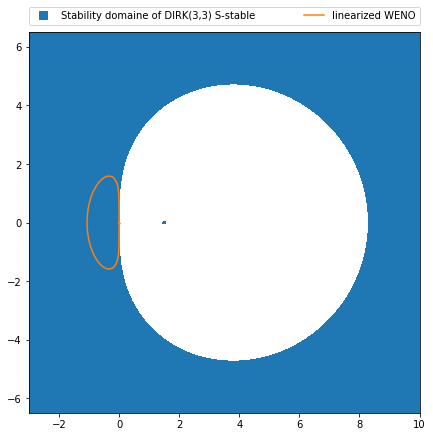

In [75]:
""" stability domain """
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(R),z,(-3,10,400),(-6.5,6.5,400),levels=[0,1.],colors=default.palette[0],label="Stability domaine of DIRK(3,3) S-stable")
plt.plot(*reim(-wenol.ztilde.data),color=default.palette[1],label=wenol.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

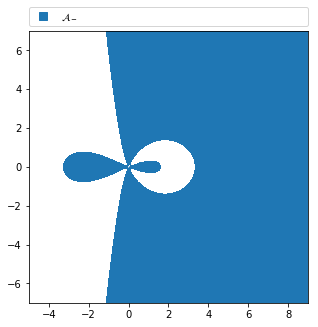

In [76]:
""" order star """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(R*sp.exp(-z)),z,(-5,9,100),(-7,7,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Un autre test issu de [numipedia](http://ketch.github.io/numipedia/methods/SSPIRK33.html), où Ketcheson présente la méthode SSPIRK(3,3). Il est à noté que je ne me suis jamais intéressé au caractère SSP d'un schéma, donc je n'ai pas lu ou vérifié cet aspect sur les précédentes méthodes DIRK présentées.

Le tableau de Butcher de la méthode SSPIRK(3,3) est :

$$
  \begin{array}{c c c | c}
    -\frac{\sqrt{2}}{4}+\frac{1}{2} & 0                               & 0                               & -\frac{\sqrt{2}}{4}+\frac{1}{2} \\
    \frac{\sqrt{2}}{4}              & -\frac{\sqrt{2}}{4}+\frac{1}{2} & 0                               & \frac{1}{2} \\
    \frac{\sqrt{2}}{4}              & \frac{\sqrt{2}}{4}             & -\frac{\sqrt{2}}{4}+\frac{1}{2} & \frac{\sqrt{2}}{4}+\frac{1}{2} \\
    \hline
    \frac{1}{3} & \frac{1}{3} & \frac{1}{3}  &
  \end{array}
$$

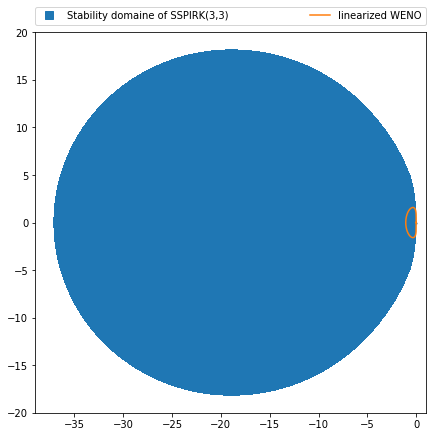

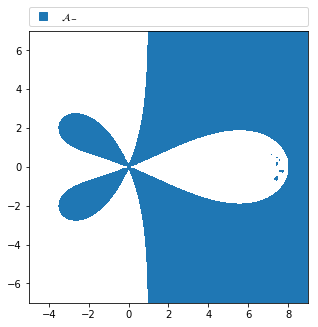

In [77]:
""" test sur SSPIRK33 (http://ketch.github.io/numipedia/methods/SSPIRK33.html) """
A = [[-sp.sqrt(2)/4+sp.Rational(1,2) , 0                             , 0                             ],
     [ sp.sqrt(2)/4                  ,-sp.sqrt(2)/4+sp.Rational(1,2) , 0                             ],
     [ sp.sqrt(2)/4                  , sp.sqrt(2)/4                  ,-sp.sqrt(2)/4+sp.Rational(1,2) ]]
b = [-sp.sqrt(2)/4+sp.Rational(1,2),sp.Rational(1,2),sp.sqrt(2)/4+sp.Rational(1,2)]
c = [sp.Rational(1,3),sp.Rational(1,3),sp.Rational(1,3)]
R = poly_dirk(A=A,c=c)
del A,b,c

""" stability domain """
plt.rcParams['figure.figsize'] = [7,7]
contourf(sp.Abs(R),z,(-39,1,50),(-20,20,50),levels=[0,1.],colors=default.palette[0],label="Stability domaine of SSPIRK(3,3)")
plt.plot(*reim(-wenol.ztilde.data),color=default.palette[1],label=wenol.name)
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()

""" order star """
plt.rcParams['figure.figsize'] = [5,5]
contourf(sp.Abs(R*sp.exp(-z)),z,(-5,9,100),(-7,7,100),levels=[0,1.],colors=default.palette[0],label="$\mathcal{A}_-$")
plt.legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()

plt.rcParams['figure.figsize'] = default.figsize

# 3. Étude de couples RK($s$,$n$)-WENO5

On regarde maintenant la stabilité de WENO avec les différents schémas RK($s$,$n$). Pour cela on trace le domaine de stabilité du schéma RK choisi, et on compare ce domaine avec celui du coefficient d'amplification du schéma WENO5. Le schéma est linéairement stable s'il existe un coefficient $\sigma$, appelé CFL, permettant de faire *rentrer* la courbe du schéma WENO dans le domaine de stabilité de RK($s$,$n$).

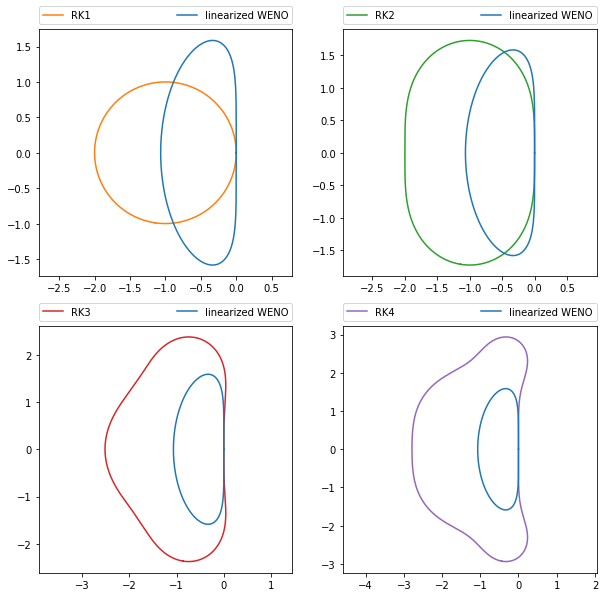

In [78]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
coords = [(x,y) for x in range(2) for y in range(2)]

for i in range(1,5):
  tmp_fig = plt.figure()
  tmp = contour(sp.Abs(poly_carac(i)),z,(-5.,2.,500),(-3.5,3.5,500), levels=[1.]).allsegs[0]
  data = max(tmp,key=lambda dat:len(dat))
  plt.close(tmp_fig); del tmp_fig,tmp
  ax[coords[i-1]].plot(data[:,0],data[:,1],label="RK%i"%i,color=default.palette[i])
  ax[coords[i-1]].plot(*reim(-wenol.ztilde.data),label=wenol.name,color=default.palette[0])
  ax[coords[i-1]].axis('equal')
  ax[coords[i-1]].legend(loc=(0.,1.02),ncol=3,mode="expand",borderaxespad=0.)
plt.show()

del fig,ax

## 3.1 Automatisation du calcul de CFL

$s$,$n$), pour $n\geq 3$ contient un rectangle contenant la courbe de WENO linéarisé. Une estimation est ainsi faite d'un $\sigma_0 \leq \sigma$. Il est possible dans un premier temps d'estimer numériquement un coefficient $\sigma_{\texttt{num}}$ tel que :

$$
  \sigma_0 \leq \sigma_{\texttt{num}} \leq \sigma
$$

travail effectué dans [[Motamed M. and Macdonald C. B. (2010)]](https://doi.org/10.1007/s10915-010-9423-9). Il est aussi possible de travailler sur la version complète du schéma WENO, en prenant en compte dans l'analyse de von Neumann de la partie non linéaire.

Pour estimer une CFL entre un couple RK($s$,$n$)-WENO(lin) :

1. On discrétise la frontière du domaine de stabilité de la méthode RK($s$,$n$), chose déjà effectuée par Python, on obtient ainsi un tableau de $\{r(\theta_k)\}_k$.
2. On discrétise le coefficient d'amplification en fonction de $\phi$ en discrétisant l'intervalle $[0,2\pi[$, on obtient ainsi un tableau des coefficients d'amplification $\{w(\phi_i)\}_i$. Il est à noter qu'il n'y a pas de raison que la discrétisation $\theta_k$ coïncide avec les $\phi_i$.
3. On trie ces 2 tableaux de données par ordre d'argument, cela sera plus simple pour les parcourir de manière similaire.
4. Pour un couple $(\varphi_i,w(\phi_i)$ donné issu de la discrétisation, on recherche l'élément $\rho(\phi)$ défini comme : $$\rho(\phi_i) = \arg\!\min_{r(\theta_k)}\left(arg(r(\theta_k)-w(\phi_i)\right)$$
5. On calcule le facteur d'homothétie locale : $$\sigma_i = \left| \frac{\rho(\phi_i)}{w(\phi_i)}\right|$$
6. On définit la CFL comme : $$\sigma = \min_i \sigma_i$$

L'étape 4 de l'algorithme peut se représenter comme suit, ici avec RK(4,4).

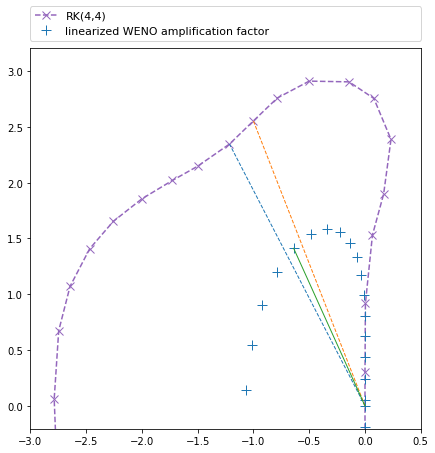

In [79]:
rk = rk44
fig = plt.figure()
reduce_data = rk.stability_domain(Ir=(-3,0.5),Ii=(-3.,3.),colors=default.palette[3]).allsegs[0][0]
plt.close(fig)
del fig

plt.rcParams['figure.figsize'] = [7,7]
plt.plot(*zip(*reduce_data[0::5]),"x--",color=default.palette[4],label="RK(4,4)",markersize=8.)
plt.plot(*reim(-wenol.ztilde.data[0::30]),"+",color=default.palette[0],label=wenol.name+" amplification factor",markersize=10.)

plt.plot([0,reduce_data[95][0]],[0,reduce_data[95][1]],"--",linewidth=1.)
plt.plot([0,reduce_data[100][0]],[0,reduce_data[100][1]],"--",linewidth=1.)
plt.plot([0,-np.real(wenol.ztilde.data[370])],[0,np.imag(wenol.ztilde.data[370])],linewidth=1.)

plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=1,mode="expand",borderaxespad=0.,prop={'size': 11})
#plt.xlabel(r"$\Re(z)$")
#plt.ylabel(r"$\Im(z)$")

plt.xlim([-3,0.5])
plt.ylim([-0.001,3])
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Pour chaque point $w(\phi_i)$ du coefficient d'amplification de WENO linéarisé, on souhaite trouver l'élément sur la bordure du domaine de stabilité de la méthode Runge-Kutta avec l'argument le plus proche de $\arg(w(\phi_i))$. Ici par exemple on trouve deux éléments $r(\theta_k)$ et $r(\theta_{k+1})$ avec un argument semblable, on choisit celui avec l'argument le plus proche.

Si on souhaite avec un résultat plus précis, il est nécessaire d'effectuer une interpolation entre les 2 éléments de la bordure du domaine de stabilité de RK(4,4) que l'on trouve. On se limite ici à une interpolation constante par morceau, la précision ne sera approtée que par le rafinement du maillage angulaire.

In [80]:
def cfl( z_rk , z_weno , display=True , data_rk=None , rk_name=None , weno_name=None ):
  sigs = np.array([ np.array([np.angle(z),np.abs((b_)/(z))]) for (z,b_) in zip(z_weno,z_rk) if np.abs(z)>1e-1 and np.abs((b_)/(z)) > 0.1 ])
  l = len(sigs)
  cfl = min(sigs[int(0.1*l):-int(0.1*l),1])
  #cfl = min(sigs[:,1])
  if cfl < 0.2:
    cfl = 0.
  if display :
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(sigs[int(0.1*l):-int(0.1*l),0],sigs[int(0.1*l):-int(0.1*l),1])
    ax[0].set_xlabel("$\\varphi$");ax[0].set_ylabel("$\\sigma_\\varphi$")
    if rk_name == None:
      rk_name = "time method"
    if weno_name == None:
      weno_name = "space method"
    if data_rk != None :
      ax[1].plot(*reim(data_rk),label=rk_name)
    else :
      ax[1].plot(*reim(z_rk),",",label=rk_name)
    ax[1].plot(*reim(-z_weno),label=weno_name)
    ax[1].plot(*reim(-z_weno*cfl),label=weno_name+" $\\times\\,\\sigma = {0:.3f}$".format(cfl))
    ax[1].axis('equal')
    plt.legend(loc=(0.,1.02),ncol=2,mode="expand",borderaxespad=0.)
    plt.show()
  return cfl

def cfl_expr ( expr , z , z_weno , Ir , Ii , display=True , rk_name=None,weno_name=None ) :
  tmp_fig = plt.figure()
  dat0 = contour(expr,z,Ir,Ii, levels=[1.]).allsegs[0] # get stability domain
  plt.close(tmp_fig); del tmp_fig
  data = max(dat0,key=lambda l:len(l)) # get main domain
  data_c = [ re+im*1j for (re,im) in zip(data[:,0],data[:,1]) ] # convert into complex
  del dat0,data
  
  # sort rk data in the same way than weno
  z_rk = np.array([ min(data_c,key=lambda zb:np.abs(np.angle(zb)-np.angle(-zw)) ) for zw in z_weno ])
  return cfl(z_rk,z_weno,display,data_c,rk_name,weno_name)

### 3.1.1 CFL RK($s$,$n$) - WENO linéarisé

On commence par expérimenter notre méthode algorithmique sur le cas WENO linéarisé et retrouver les CFL proposées dans [[Motamed M. and Macdonald C. B. (2010)]](https://doi.org/10.1007/s10915-010-9423-9) ou [[Thibaut L. et al.]](https://doi.org/10.1175/MWR-D-16-0343.1).

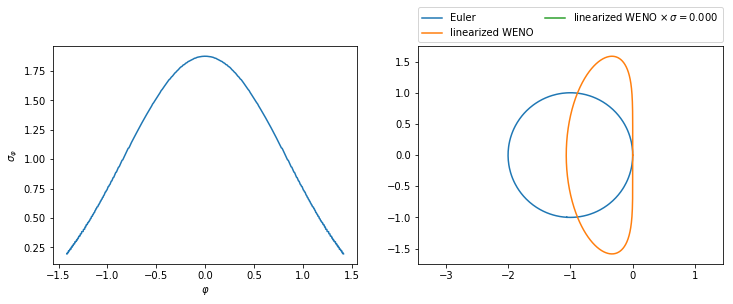

In [81]:
rk1.cfl = {}
rk1.cfl[wenol.name] = cfl_expr( sp.Abs(rk1.stability_function()),z,wenol.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk1.label,wenol.name)
display(rk1.cfl[wenol.name])

On confirme bien avec ce résultat l'aspect instable du couple EE-WENO5 démontré par dans [[R. Wang and R. J. Spiteri (2007)]](https://doi.org/10.1137/050637868).

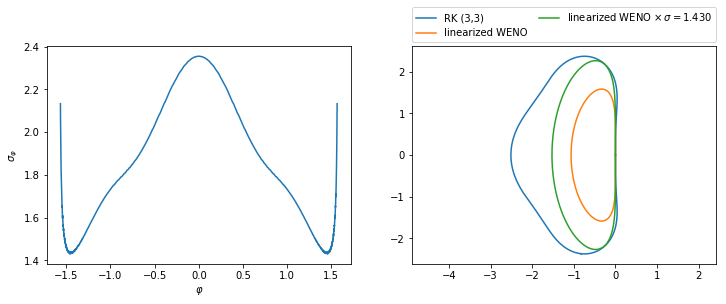

In [82]:
rk33.cfl = {}
rk33.cfl[wenol.name] = cfl_expr( sp.Abs(rk33.stability_function()),z,wenol.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk33.label,wenol.name)
display(rk33.cfl[wenol.name])

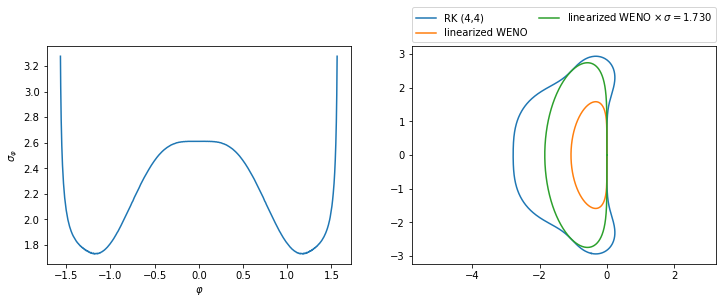

In [83]:
rk44.cfl = {}
rk44.cfl[wenol.name] = cfl_expr( sp.Abs(rk44.stability_function()),z,wenol.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk44.label,wenol.name)
display(rk44.cfl[wenol.name])

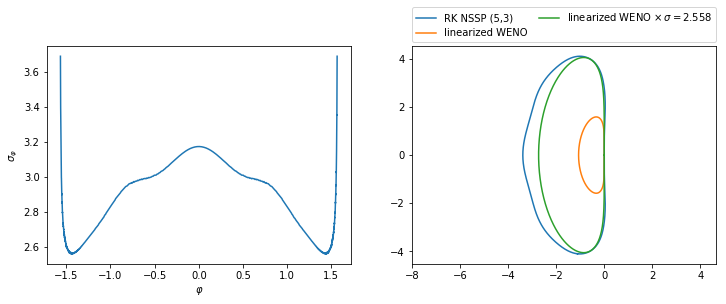

In [84]:
rk53.cfl = {}
rk53.cfl[wenol.name] = cfl_expr( sp.Abs(rk53.stability_function()),z,wenol.ztilde.data,(-6.,3.,500),(-6.,6.,500),
         True,rk53.label,wenol.name)
display(rk53.cfl[wenol.name])

On récapitule les CFL obtenues :

|         -          | Euler | RK(3,3) | RK(5,3) | RK(4,4) |
|--------------------|-------|---------|---------|---------|
| [[Thibaut L. et al.]](https://doi.org/10.1175/MWR-D-16-0343.1) | 0.00 | 1.44 | 2.14 | 1.73 |
| **WENO linéarisé** | 0     | 1.430   | 2.558   | 1.730   |

Je n'arrive pas à expliquer la différence sur le schéma RK(5,3) entre [[Thibaut L. et al.]](https://doi.org/10.1175/MWR-D-16-0343.1) et ma méthode de calcul de CFL avec WENO linéarisé.

# 4. Schémas Runge-Kutta exponentiels

L'EDP que nous cherchons à résoudre est l'équation de Vlasov :

$$
  \partial_t f + v\partial_x f + E(f)\partial_v f = 0
$$

le champ électrique $E$ dépend de $f$ (via l'équation de Poisson) ce qui rend ce transport non linéaire. On commence par effectuer une transformée de Fourier en $x$ :

$$
  \partial_t \hat{f}_k + ikv\hat{f}_k + \widehat{\left(E(f)\partial_vf\right)}_k = 0\quad\forall k
$$

problème que l'on peut synthétiser sous la forme :
$$
  \dot{u} = Lu + N(u)
$$

où $u\equiv\hat{f}_k$, $L\equiv -ikv$ le transport linéaire et $N:u\mapsto N(u)\equiv f\mapsto-\widehat{\left(E(f)\partial_vf\right)}_k$. L'intérêt de cette forme synthétique est qu'elle a fait l'objet d'études pour sa résolution en menant à 2 classes de schémas.

Pour résoudre ce problème, il est intéressant de le reformuler comme :
$$
  \partial_t\left(e^{-Lt}u\right) = e^{-Lt}N(u)
$$

Pour construire un schéma en temps, il faut intégrer sur $[t^n,t^{n+1})$ :
$$
  \int_{t^n}^{t^{n+1}}\partial_t\left(e^{-Lt}u\right)\,\mathrm{d}t = \int_{t^n}^{t^{n+1}}e^{-Lt}N(u)\,\mathrm{d}t
$$

On évalue de manière exacte le terme de gauche :
$$
  e^{-Lt^n}\left(e^{-L\Delta t}u(t^{n+1})-u(t^n)\right) = \int_{t^n}^{t^{n+1}}e^{-Lt}N(u)\,\mathrm{d}t
$$

En effectuant le changement de varibale $\tau = t-t^n$ on trouve une intégrale seulement sur le pas de temps $\Delta t$, ce qui est rassurant quant à la stabilité numérique en temps long (à propos des *overflow* ou *underflow* possibles produits par la fonction exponentielle).

Les deux classes de schémas que nous allons présenter par la suite diffèrent sur l'approximation de l'intégrale $\int_{t^n}^{t^{n+1}}e^{-Lt}N(u)\,\mathrm{d}t$, une première classe de schémas consistera à résoudre l'exponentielle de manière exacte en effectuant une interpolation sur $N(u(t))$, la seconde classe consistera à effectuer une interpolation sur toute l'intégrale ce qui permet de se ramener directement à la résolution d'une méthode de type Runge-Kutta.

## 4.1 Schémas exponentiels

La stratégie pour construire le schéma en temps d'un schéma exponentiel est d'effectuer une approximation sur $u(t)$, par exemple pour obtenir la méthode exponentiel Runge-Kutta d'ordre 1 on effectue l'approximation $u(t) \approx u(t^n)$. On obtient alors :n obtient alors :

$$
  e^{-L\Delta t}u^{n+1} - u^n = N(u^n)\frac{1}{L}(1-e^{-L\Delta t})
$$
soit :
$$
  u^{n+1} = e^{L\Delta t}u^n + \frac{e^{L\Delta t}-1}{L}N(u^n)
$$

Dans le cas qui nous intéresse, $L\in i\mathbb{R}$, pour étudier la stabilité du schéma on se propose de poser :

* $L\Delta t = i\beta$.
* $z = \mu \Delta t$ avec $\mu$ la linéarisation (par analyse de *von Neumann*) de $N$.

On obtient alors l'expression suivante :
$$
  u^{n+1} = \left( e^{i\beta} + \frac{z}{i\beta}(e^{i\beta}-1)\right)u^n
$$

On souhaite alors étudier ce coefficient d'amplification :
$$
  R(\beta,z) = \left|e^{i\beta}-i\frac{z}{\beta}(e^{i\beta}-1)\right|
$$
En factorisant par $e^{i\beta}$, qui est de module 1, on obtient :
$$
  R(\beta,z) = \left| 1 + i\frac{z}{\beta}(e^{-i\beta}-1) \right|
$$
On peut donc prédire que le domaine de stabilité dépend de la partie linéaire de notre équation.

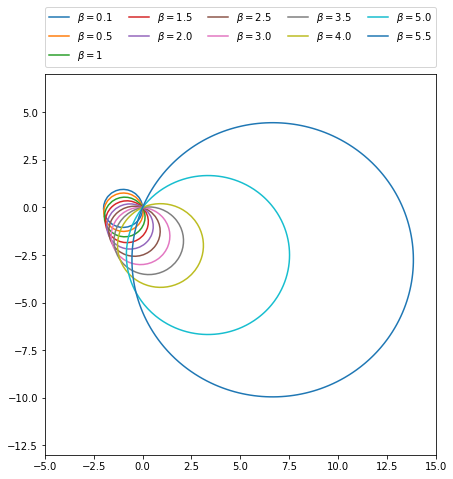

In [85]:
""" test on expRK(1,1) method """

bet,a,b = sp.symbols(r"\beta a b",real=True)
z = sp.symbols("z",complex=True)
R = sp.Abs(sp.exp(I*bet) - I*z/bet*(sp.exp(I*bet)-1))

plt.rcParams['figure.figsize'] = [7,7]
for i,k in enumerate([0.1,0.5,1,1.5,2.0,2.5,3.0,3.5,4.0,5.0,5.5]):
  contour( R.subs(bet,k) , z , (-5,15,100) , (-13,7,100) , levels=[1.] , colors=default.palette[i%len(default.palette)] , label=r"$\beta = {}$".format(k))

del bet,a,b,i,k
plt.legend(loc=(0.,1.02),ncol=5,mode="expand",borderaxespad=0.,markerscale=8)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Les schémas exponentiels peuvent aussi s'écrire sous la forme d'un tableau de Butcher légèrement modifié. (Pour me simplifier la vie je reprends les notations de Lukas) On s'intéresse à la résolution d'un problème du type :

$$
  \dot{u} + Au = g(t,u)
$$

On a le tableau de Butcher suivant :

$$
  \begin{array}{c|c}
    \begin{matrix} c_1 \\ \vdots \\ c_s \end{matrix} & \begin{matrix}
      a_{11} & \cdots & a_{1s} \\
      \vdots & \ddots & \vdots \\
      a_{s1} & \cdots & a_{ss}
    \end{matrix} \\ \hline
     & \begin{matrix}b_1 & \cdots & b_s \end{matrix} \\
  \end{array}
$$

> **Attention :** les notations $b$ et $c$ sont inversées par rapport à la présentation précédente des tableaux de Butcher.

> **Nota bene :** nous ne nous intéressons qu'à des méthodes explicites (à cause de WENO) donc la matrice $(a)_{i,j}$ est triangulaire strictement inférieure.

Le schéma associé à ce tableau s'écrit comme :

$$
  \begin{aligned}
    G_{nj}  &= g(t^n+c_jh,U_{nj}) \\
    U_{ni}  &= \chi_i(-hA)u_n + h\sum_{j=1}^{s}a_{ij}(-hA)G_{nj} \\
    u^{n+1} &= \chi(-hA)u_n   + h\sum_{i=1}^{s}b_i(-hA)G_{ni}
  \end{aligned}
$$

avec les fonctions :
* $\chi(z) = e^z$
* $\chi_i(z) = e^{c_iz}$

Les coefficients $a_{i,j}$ et $b_i$ sont des fonctions pouvant faire intervenir les fonctions :

* $$\varphi_i(z) = \frac{e^z-\sum_{k=0}^{i-1}\frac{1}{k!}z^k}{z^i}$$
* $$\varphi_{i,j} = \varphi_{i,j}(-hA) = \varphi_i(-c_jhA)$$

$h$ représente le pas de temps dans notre cas, $A$ est la fonction linéaire, dans le cas de Vlasov-Poisson après FFT en $x$ on a $A=i\kappa v$.

In [98]:
def phi(i,j=None):
  if j==None:
    return sp.symbols("\\varphi_%d"%i)
  else:
    return sp.symbols("\\varphi_{%i\,%i}"%(i,j))

def phii(i,z):
  return (sp.exp(z)-sum([sp.Rational(1,sp.factorial(k))*z**k for k in range(0,i)]))/(z**i)

def chi(z):
  return sp.exp(z)

def chii(i,z):
  return chi(vc[i]*z)

h = sp.symbols("h")
A = sp.symbols("A")
g = sp.Function("g")

In [99]:
def exprk_butcher_scheme ( mA , vb , vc , A , g ):
  """
    return scheme from Butcher tableau of an exponentiel Runge-Kutta method
  """
  us = name_stages("u",len(vc))
  scheme_stages = []
  r = range(len(vc))
  u_s = [ 0 for i in r ]
  for i in r:
    u_si = us[0] + h*sum([ mA[i][j]*(g(us[j]) - A*us[0]) for j in r ])
    scheme_stages.append(sp.Eq(us[i],u_si.expand().collect(us).collect([g(us[i]) for i in r])))
  un1 = us[0] + h*sum([ vb[i]*(g(us[i]) - A*us[0]) for i in r ])
  scheme_stages.append(sp.Eq(us[-1],un1.expand().collect(us).collect([g(us[i]) for i in r])))
  
  return scheme_stages[1:]

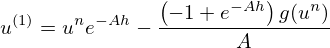

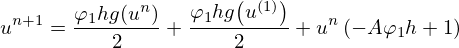

In [101]:
# expRK(2,2) alternatif sans $\phi_2$
c2 = 1 #sp.Rational(1,2) #sp.symbols("c_2")

mA = [[0 , 0],
     [c2*phi(1,2),0]]
vc = [0,c2]
vb = [(1-sp.Rational(1,2*c2))*phi(1),sp.Rational(1,2*c2)*phi(1)]

[ display(eq.subs(phi(1,2),phii(1,-vc[2-1]*h*A))) for eq in exprk_butcher_scheme(mA,vb,vc,A,g) ];

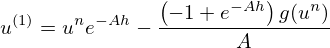

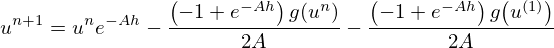

In [103]:
subs_phi = [ (phi(i,j),phii(i,-vc[j-1]*h*A)) for j in range(len(vc)+1) for i in range(j+1) ] # helper for substitution of phi functions
subs_phi.extend([(phi(i),phii(i,-h*A)) for i in range(len(vc)+1)])

[ display(eq.subs(subs_phi)) for eq in exprk_butcher_scheme(mA,vb,vc,A,g) ];

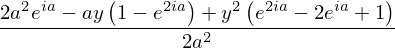

In [105]:
def expRK_poly( scheme ):
  expr = scheme[-1]
  us = name_stages("u",len(vc))
  s = len(scheme)
  a = sp.symbols("a")
  for i,uk in enumerate(reversed(scheme[:-1])) :
    expr = expr.subs(uk.lhs,uk.rhs)
  return expr.rhs.subs(subs_phi).replace(g,lambda x:lamb*x).expand().subs(lamb,z).subs(h,1).subs(A,-I*a).subs(us[0],1).collect(z)

expRK22 = expRK_poly(exprk_butcher_scheme(mA,vb,vc,A,g))
expRK22.subs(z,I*y).simplify().expand().collect(y).simplify()

Maintenant que l'on a une fonction pour calculer la fonction de stabilité d'une méthode de type exponentiel Runge-Kutta, traçon son domaine de stabilité :

$$
  \mathcal{D} = \left\{ z\in\mathbb{C} / |p(z)|\leq 1 \right\}
$$

En regardant la fonction de stabilité de la méthode expRK(2,2) on se rend compte que celle-ci dépend de $a$ qui correspond ici au terme linéaire, il est donc intéressant de tracer ce domaine pour différentes valeurs de $a$.

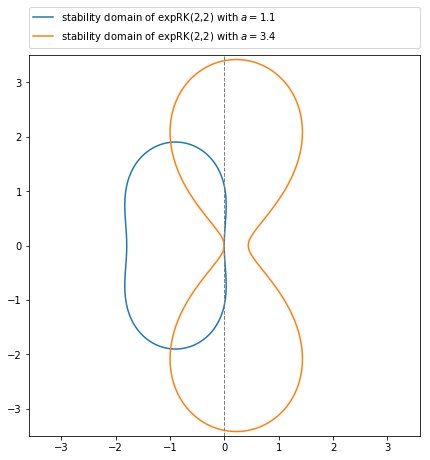

In [117]:
plt.rcParams['figure.figsize'] = [7,7]
for i,a in enumerate((1.1,3.4)):
  contour(sp.Abs(expRK22.subs(sp.symbols("a"),a)),z,(-2,2,500),(-3.5,3.5,500),levels=[1.],colors=default.palette[i],label="stability domain of expRK(2,2) with $a={}$".format(a))
plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
plt.axis('equal')
plt.legend(loc=(0.,1.02),ncol=1,mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

En jouant sur le paramètre $a$ on remarque vite qu'il ne sera pas possible de stabiliser une méthode WENO avec ce type de schéma, en effet quelques simulations ont vite montré l'instabilité de ce couple de schéma (même dans un contexte $\Delta t \ll \Delta v$, donc largement sous une hypothétique CFL du type $\Delta t \leq \sigma \Delta v$). Une partie de l'axe imaginaire est toujours présent dans le domaine de stabilité, on peut donc essayer d'y stabilisé un méthode de différences finies centrée d'ordre 2 (CD2). Pour cela calculons une valeur $y_\text{max}$ définie comme :

$$
  y_\text{max} = \min_{y\in\mathbb{R}}\left\{ |y|\ /\ |p(iy)| \leq 1 \right\}
$$

Le domaine de stabilité, non forcément connexe, impose l'utilisation d'un minimum ; on recherche bien la plus petite valeur où le domaine de stabilité coupe l'axe imaginaire.

Dans un premier temps on va définir $y_+(a)$ et $y_-(a)$ correspondant à :

$$
  y_+(a) = \min_{y\in\mathbb{R}_+}\left\{ y\ /\ |p_a(iy)| \leq 1 \right\} \qquad y_-(a) = \min_{y\in\mathbb{R}_-}\left\{ y\ /\ |p_a(iy)| \leq 1 \right\}
$$

où $p_a$ correspond à la fonction de stabilité pour un $a$ donné. On peut interpréter cela comme les 2 bornes telles que le segement $i[y_-,y_+]\subset\mathcal{D}$. On calcule donc pour chaque valeur du paramètre $a$, les bornes du domaine de stabilité, par la suite, $y_\text{max}$ peut être défini comme :

$$
  y_\text{max} = \min_{a\in\mathbb{R}}\left\{ y_+(a),|y_-(a)| \right\}
$$

In [224]:
def expRK_ypm ( exprk_poly , seuil=1.00 , na=1.0 ) :
  linYp = np.linspace(0,5,500)
  linYm = np.linspace(0,-5,500)
  dy = linYp[1]-linYp[0]
  import itertools

  ymax_a = []
  
  a = sp.symbols("a")
  tmp = exprk_poly.subs(a,na)
  if na == 0. :
    tmp = sp.Limit(exprk_poly,a,na).doit()
  yp = min(itertools.chain(linYp[ sp.lambdify(y,sp.re(sp.Abs(tmp)),'numpy')(linYp) > seuil ]),default=dy)-dy
  ym = min(itertools.chain(linYm[ sp.lambdify(y,sp.re(sp.Abs(tmp)),'numpy')(linYm) > seuil ]),key=lambda x:np.absolute(x),default=-dy)+dy
  
  return (yp,ym)

In [232]:
def test_na ( meth , listA ):
  ncols=3
  nrows=len(listA)//ncols
  fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(4.5*ncols,4.5*nrows))
  for i,na in enumerate(listA) :
    if na == 0:
      tmp = sp.Limit(meth,sp.symbols("a"),na).doit()
    else:
      tmp = meth.subs(sp.symbols("a"),na)
    ax[i//ncols][i%ncols].axvline(0, color='gray',linestyle='--',linewidth=1.)
    tmp_fig = plt.figure()
    tmp = contour( sp.Abs(tmp) , z , (-5,3,500),(-4,4,500) , levels=[1.] ).allsegs[0]
    plt.close(tmp_fig); del tmp_fig
    
    for data in tmp:
      ax[i//ncols][i%ncols].plot(data[:,0],data[:,1],"-",color=default.palette[i])
    ax[i//ncols][i%ncols].plot([0],[0],'-',color=default.palette[i],label=r"$a\Delta t = {:.3f}$".format(na))
    
    ax[i//ncols][i%ncols].axvline(0, color='gray',linestyle='--',linewidth=1. )
    ax[i//ncols][i%ncols].set_xlim([-5,3.]); ax[i//ncols][i%ncols].set_ylim([-4,4])

    yp,ym = expRK_ypm(meth.subs(z,I*y),seuil=1.,na=na)
    ax[i//ncols][i%ncols].plot([0],[0],',',label=r"$y_\max = {:.3f}$".format(min([yp,ym],key=np.absolute)))

    ax[i//ncols][i%ncols].plot([0],[yp],"+",markersize=11,color="#00bb99")
    ax[i//ncols][i%ncols].annotate(r"$y_+ = {:.3f}$".format(yp),xy=(-0.1,yp),xytext=(-3,2),arrowprops=dict(arrowstyle="->"),fontsize=12)
    ax[i//ncols][i%ncols].plot([0],[ym],"x",markersize=11,color="#ff00bb")
    ax[i//ncols][i%ncols].annotate(r"$y_- = {:.3f}$".format(ym),xy=(-0.1,ym),xytext=(-3,-1.2),arrowprops=dict(arrowstyle="->"),fontsize=12)

    ax[i//ncols][i%ncols].legend(loc=(0.,1.02),ncol=2,mode="expand",borderaxespad=0.,prop={'size': 11})
    ax[i//ncols][i%ncols].set_xlabel("$\\Re(z)$")
    ax[i//ncols][i%ncols].set_ylabel("$\\Im(z)$")

  plt.show()

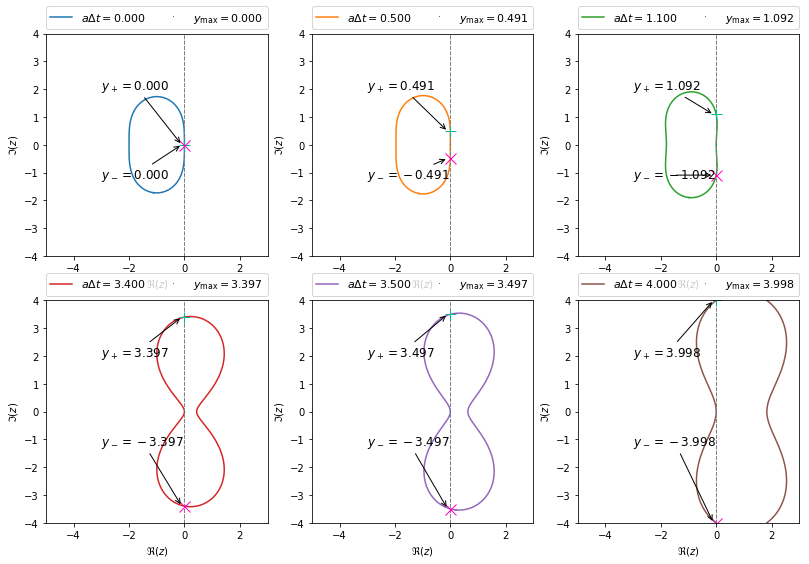

In [233]:
test_na(expRK22,(0.,0.5,1.1,3.4,3.5,4.))

In [227]:
# Krogstad
mA = [[0,0,0,0],
      [sp.Rational(1,2)*phi(1,2)         ,0       ,0         ,0],
      [sp.Rational(1,2)*phi(1,3)-phi(2,3),phi(2,3),0         ,0],
      [phi(1,4)-2*phi(2,4)               ,0       ,2*phi(2,4),0]]
vc = [0,sp.Rational(1,2),sp.Rational(1,2),1]
vb = [phi(1)-3*phi(2)+4*phi(3),2*phi(2)-4*phi(3),2*phi(2)-4*phi(3),-phi(2)+4*phi(3)]

subs_phi = [ (phi(i,j),phii(i,-vc[j-1]*h*A)) for j in range(len(vc)+1) for i in range(j+1) ]
subs_phi.extend([(phi(i),phii(i,-h*A)) for i in range(len(vc)+1)])

Krogstad = expRK_poly([ eq.subs(subs_phi) for eq in exprk_butcher_scheme(mA,vb,vc,A,g)])

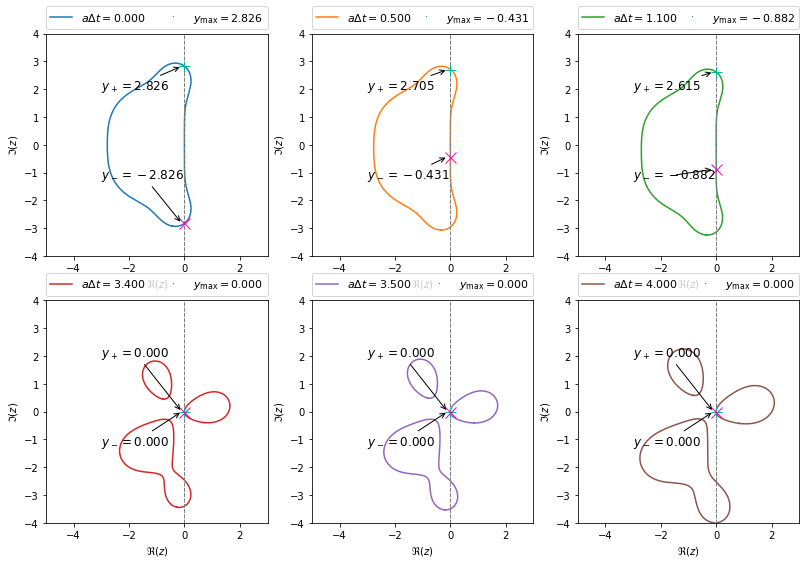

In [234]:
test_na(Krogstad,(0.,0.5,1.1,3.4,3.5,4.))

Ce que l'on observe c'est une asymétrie entre $y_+$ et $y_-$ pour des schémas d'ordre plus élevé que 2 (ici le schéma Krogstad est d'ordre 4). De plus, la CFL avec CD2 que l'on définit comme étant notre $y_\text{max}$ tombe à zéro.

Pour justifier que ce type de schéma est utilisable en pratique avec CD2 nous effectuons une relaxation de la condtion CFL en définissant le domaine de stabilité comme :

$$
  \mathcal{D}_\varepsilon = \left\{ z\in\mathbb{C} : |p(z)|\leq 1+\varepsilon \right\}
$$

Illustrons cette relaxation.

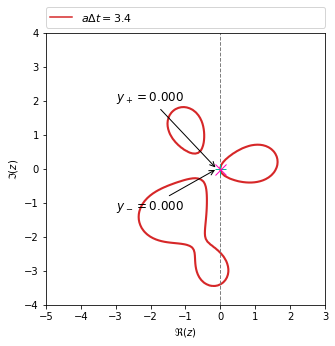

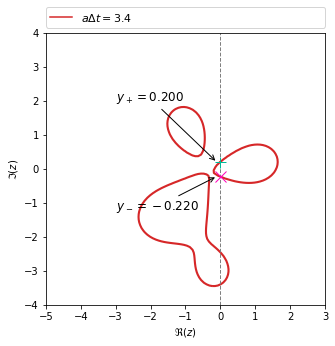

In [230]:
plt.rcParams['figure.figsize'] = [5,5]
for meth in [Krogstad] :
  for epsi in [0.,0.01]:
    contour( sp.Abs(meth).subs(sp.symbols("a"),3.4) , z , (-5,3,100),(-4,4,100) , levels=[1.+epsi] ,
              colors=default.palette[3] , linewidths=2.1 , linestyles="solid" ,
              label=r"$a\Delta t = {}$".format(3.4) )

    plt.axvline(0, color='gray',linestyle='--',linewidth=1.)
    yp,ym = expRK_ypm(meth.subs(z,I*y),seuil=1.+epsi,na=3.4)
    display(sp.Eq(sp.symbols(r"\varepsilon"),epsi))
    display(min([yp,ym],key=np.absolute))
    plt.plot([0],[yp],"+",markersize=11,color="#00bb99")
    plt.annotate(r"$y_+ = {:.3f}$".format(yp),xy=(-0.1,yp),xytext=(-3,2),arrowprops=dict(arrowstyle="->"),fontsize=12)
    plt.plot([0],[ym],"x",markersize=11,color="#ff00bb")
    plt.annotate(r"$y_- = {:.3f}$".format(ym),xy=(-0.1,ym),xytext=(-3,-1.2),arrowprops=dict(arrowstyle="->"),fontsize=12)

    plt.legend(loc=(0.,1.02),ncol=2,mode="expand",borderaxespad=0.,prop={'size': 11})
    plt.xlabel("$\\Re(z)$")
    plt.ylabel("$\\Im(z)$")

    plt.show()
plt.rcParams['figure.figsize'] = default.figsize

On justifie ce calcul de CFL par le fait que la CFL au sens strict : $\Delta t \leq \sigma\Delta v$ est valable pour une stabilité en temps infini, or nos simulations s'effectuent en temps fini, nous n'avons pas besoin de stabilité $L^2$, juste locale en temps. On *contrôle* donc l'instabilité par un $\Delta t$ suffisamment petit, impliquant une augmentation *raisonnable* de l'erreur.

## 4.2 Schémas de Lawson

Plaçons nous dans un cas plus général que le cas d'opérateurs linéarisés, considérons l'équation suivante :

$$
  \dot{u} = Lu + N(u)
$$

avec $L$ un opérateur linéaire et $N$ un opérateur non-linéaire. On peut écrire une formulation exponentielle de la forme :

$$
  \left(e^{-L t}u\right)_t = e^{-L t}N(u)
$$

Notons $v=e^{-L t}u$, et considérons alors l'opérateur non linéaire $(v,t)\mapsto\tilde{N}(v,t) = e^{-L t}N(e^{L t}v)$ ; l'équation devient, avec ces nouvelles notations :

$$
  \dot{v} = \tilde{N}(v,t)
$$

Équation que l'on peut résoudre à l'aide d'un schéma RK classique, ici le schéma RK SSP(3,3) aussi dit de Shu-Osher :

$$
  \begin{aligned}
    v^{(1)} &= v^n + \Delta t \tilde{N}(v^n,t^n) \\
    v^{(2)} &= \frac{3}{4}v^n + \frac{1}{4}v^{(1)} + \frac{1}{4}\Delta t \tilde{N}(v^{(1)},t^n+\Delta t) \\
    v^{n+1} &= \frac{1}{3}v^n + \frac{2}{3}v^{(2)} + \frac{2}{3}\Delta t \tilde{N}(v^{(2)},t^n+\frac{1}{2}\Delta t) \\
  \end{aligned}
$$

Ce qui nous donne en fonction de $u$ :

$$
  \begin{aligned}
    v^{(1)} &= e^{-L t^n}u^n + \Delta t e^{-L t^n}N(u^n) \\
    v^{(2)} &= \frac{3}{4}e^{-L t^n}u^n + \frac{1}{2}v^{(1)} + \frac{1}{4}\Delta t e^{-Lt^n}e^{-L\Delta t}N(e^{Lt^n}e^{L\Delta t}v^{(1)}) \\
    e^{-L t^n}e^{-L\Delta t}u^{n+1} &= \frac{1}{3}e^{-L t^n}u^n + \frac{2}{3}v^{(2)} + \frac{2}{3}\Delta t e^{-Lt^n}e^{-\frac{1}{2}L\Delta t}N(e^{Lt^n}e^{\frac{1}{2}L\Delta t}v^{(2)})
  \end{aligned}
$$

Pour des raisons purement numériques liées à la précision machine, simplifions dès que possible par $e^{-Lt^n}$ pour s'assurer que le schéma ne dégénère pas en temps long :

$$
  \begin{aligned}
    \tilde{u}^{(1)} &= u^n + \Delta t N(u^n) \\
    \tilde{u}^{(2)} &= \frac{3}{4}u^n + \frac{1}{2}\tilde{u}^{(1)} + \frac{1}{4}\Delta t e^{-L\Delta t}N(e^{L\Delta t}\tilde{u}^{(1)}) \\
    u^{n+1} &= \frac{1}{3}e^{L\Delta t}u^n + \frac{2}{3}e^{L\Delta t}\tilde{u}^{(2)} + \frac{2}{3}\Delta t e^{\frac{1}{2}L\Delta t}N(e^{\frac{1}{2}L\Delta t}\tilde{u}^{(2)})
  \end{aligned}
$$

Les coefficients exponentiels à l'intérieur de l'opérateur non-linéaire nous incitent à poser :

* $u^{(1)} = e^{L\Delta t}\tilde{u}^{(1)}$
* $u^{(2)} = e^{\frac{1}{2}L\Delta t}\tilde{u}^{(2)}$

D'où le schéma suivant :

$$
  \begin{aligned}
    u^{(1)} &= e^{L\Delta t}u^n + \Delta t e^{L\Delta t} N(u^n) \\
    u^{(2)} &= \frac{3}{4}e^{\frac{1}{2}L\Delta t}u^n + \frac{1}{4}e^{-\frac{1}{2}L\Delta t}u^{(1)} + \frac{1}{4}\Delta t e^{-\frac{1}{2}L\Delta t}N(u^{(1)}) \\
    u^{n+1} &= \frac{1}{3}e^{L\Delta t}u^n + \frac{2}{3}e^{\frac{1}{2}L\Delta t}u^{(2)} + \frac{2}{3}\Delta t e^{\frac{1}{2}L\Delta t}N(u^{(2)})
  \end{aligned}
$$

On retrouve ainsi le schéma proposé dans [[Isherwood L. et al (2018)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2018-Isherwood(1).pdf).

Pour la fonction de stabilité d'une méthode de Lawson, intéressons-nous au cas où $N$ est une fonction linéaire, on a alors :

$$
  v^{n+1} = p_{RK(s,n)}(N\Delta t)v^{n}
$$

en repassant à la $u$ on a :

$$
  e^{-L(t^n+\Delta t)}u^{n+1} = p_{RK(s,n)}(N\Delta t)e^{-Lt^n}u^n
$$

soit :

$$
  u^{n+1} = e^{L\Delta t}p_{RK(s,n)}(N\Delta t)u^n
$$

Cela nous permet d'exprimer la fonction de stabilité d'une méthode de Lawson induite par la méthode RK($s$,$n$), et d'en déduire directement que si $L\in i\mathbb{R}$ alors le domaine de stabilité sera identique à la méthode Runge-Kutta sous-jacente.

On peut retrouver ce résultat pour une méthode particulière, par exemple pour RK(3,3).

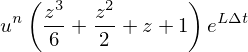

In [88]:
L,mu = sp.symbols(r"L \mu")
def N (u) :
  return mu*u

u1 = sp.exp(L*dt)*un + dt*sp.exp(L*dt)*N(un)
u2 = sp.Rational(3,4)*sp.exp(sp.Rational(1,2)*L*dt)*un + sp.Rational(1,4)*sp.exp(-sp.Rational(1,2)*L*dt)*u1 + sp.Rational(1,4)*dt*sp.exp(-sp.Rational(1,2)*L*dt)*N(u1)
un1 = sp.Rational(1,3)*sp.exp(L*dt)*un + sp.Rational(2,3)*sp.exp(sp.Rational(1,2)*L*dt)*u2 + sp.Rational(2,3)*dt*sp.exp(sp.Rational(1,2)*L*dt)*N(u2)

display(un1.subs(mu*dt,z).expand().collect(un).collect(z).collect(sp.exp(dt*L)))

del L,mu,N

Le cas $L\in i\mathbb{R}$ est celui qui nous intéressera le plus par la suite, à cause de l'utilisation de méthode spectrale dans une direction et d'une méthode WENO dans l'autre. Ce cas ne changeant pas le domaine de stabilité, il n'est pas nécessaire d'effectuer de nouvelle étude sur la stabilité d'une telle méthode.

Il est possible d'automatiser la méthode d'obtention du schéma de Lawson (ou IFRK) pour la résolution de l'équation :

$$
  \dot{u} = Lu + N(u)
$$

à partir d'un tableau de Butcher de la méthode RK associée. La méthode algorithmique mise en place consiste à :

1. Écrire le schéma RK de base en $v=e^{-Lt}u$ et $\tilde{N}(t,v)=e^{-Lt}N(e^{Lt}v)$, on obtient ainsi une méthode de résolution du problème :

    $$
      \partial_t v = \tilde{N}(t,v)
    $$
    
2. Substituer :
    - $v^n \mapsto e^{-Lt^n}u^n$
    - $v^{n+1} \mapsto e^{-L(t^n+\Delta t)}u^{n+1}$
    - $v^{(i)} \mapsto e^{-L(t^n+b_i\Delta t)}u^{(i)}$

Il est possible d'effectuer ce même travail à partir de l'écriture sous forme de schéma, mais il est plus compliqué d'un point de vue informatique de gérer des expressions plutôt que des tableaux. Il s'agit donc uniquement d'une contrainte technique.

> On remarquera que le schéma ainsi obtenu n'est pas optimal dans le sens où il y a plus que $s$ appels à la fonction non linéaire $N$, chose évitée souvent dans l'écriture sous forme de schéma, comme c'est le cas pour la méthode RK3 de Shu-Osher. Il est donc possible de substituer récurisvement, grâce aux équations précédentes, les valeurs des différentes évaluations de la fonction $N$.

In [93]:
L = sp.symbols("L")
N = sp.Function("N",nargs=1)
tn = sp.symbols("t^n",real=True)

#Nt = sp.Function("\\tilde{N}",nargs=2)
def Nt(t,v):
  """ `Nt` for N tilde, just for `ifrk` scheme """
  return sp.exp(-L*t)*N(sp.exp(L*t)*v)

def ifrk ( A , b , c , shu_osher=False ):
  """
    return Lawson, or IFRK scheme of table of Butcher `A`, `b`, `c`. `shu_osher` boolean parameter is
    to optimize callee of non-linear function $N$
  """
  vs = name_stages("v",len(c))
  us = name_stages("u",len(c))
  
  # write scheme with $\tilde{N}(t,v) = e^{-Lt}N(e^{Lt}v)$ and $v=e^{-Lt}u$
  scheme_stages = []
  r = range(len(c))
  u_s = [ 0 for i in r ]
  for i in r:
    u_si = vs[0] + dt*sum([ A[i][j]*Nt(tn+b[j]*dt,vs[j]) for j in r ])
    eq = sp.Eq(vs[i],u_si)
    # on ne prend en considération les étapes différentes de u^0 = u^n.
    if eq != True :
      scheme_stages.append(eq)
  un1 = vs[0] + sum([ dt*c[i]*Nt(tn+b[i]*dt,vs[i]) for i in r ])
  scheme_stages.append(sp.Eq(sp.symbols("v^{n+1}"),un1))
  
  # substitut all occurences of $v$ by $u$
  vs_us = dict([ (v,u) for (v,u) in zip(vs,us) ])
  vs_usexp = dict([ (v,u*sp.exp(-L*(tn+bs*dt))) for (v,u,bs) in zip(vs,us,b) ])
  vs_usexp[vs[-1]] = us[-1]*sp.exp(-L*(tn+dt))
  
  tmp = [ sp.Eq(us,(sp.solve(eq.subs(vs_usexp),us)[0]).simplify().expand()) for (eq,bs,us) in zip(scheme_stages,b,us[1:]) ]
  
  # simplification by substitution to evaluate only s times N
  if shu_osher:
    N_subs = []
    for i,eq in enumerate(tmp[:-1]):
      tmp[i] = eq.subs(N_subs).simplify().expand()
      N_subs.append((N(us[i]),sp.solve(tmp[i],N(us[i]))[0]))
    tmp[-1] = tmp[-1].subs(N_subs).expand()
  
  return tmp

rk_butcher.ifrk = lambda self,shu_osher=False:ifrk(self.A,self.b,self.c,shu_osher)

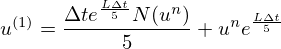

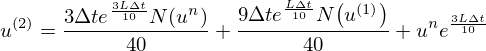

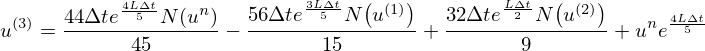

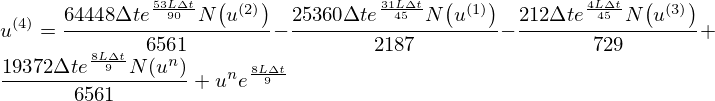

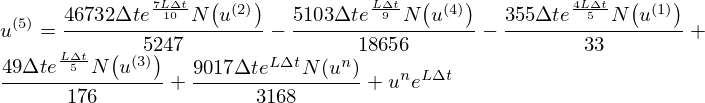

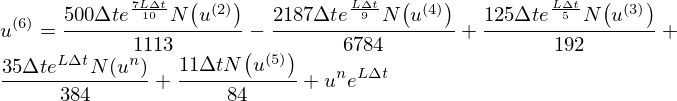

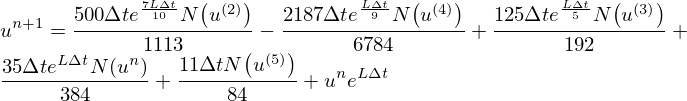

In [94]:
[ display(eq) for eq in dp5.ifrk() ];

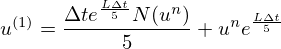

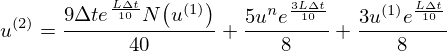

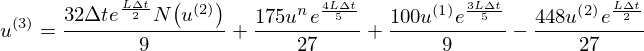

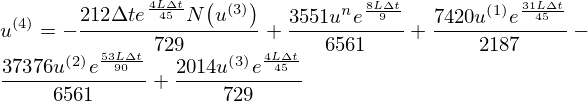

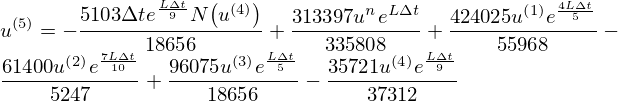

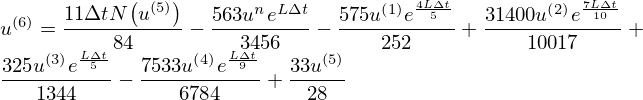

In [96]:
[ display(eq) for eq in dp5.ifrk(shu_osher=True) ];

Dans le contexte de $L\in i\mathbb{R}$, il n'est pas nécessaire de poursuivre l'étude de stabilité de la méthode de Lawson, celle-ci pouvant se ramener à l'étude de stabilité d'une méthode de type Runge-Kutta, que nous avons déjà présenté.